# 0. Imports

## 0.1. Libraries

In [1]:
# Data Manipulation Libraries
import numpy  as np
import pandas as pd

# Data Visualization Libraries
import seaborn        as sns
from matplotlib       import cm
from matplotlib       import pyplot  as plt
from plotly           import express as px
from pandas_profiling import ProfileReport

# Data Processing Libraries
from sklearn import preprocessing as pp

# Dimensionality Reduction Libraries
import umap.umap_ as umap
from sklearn          import decomposition as dd
from sklearn          import ensemble      as en
from sklearn.manifold import TSNE

# Model Libraries
from sklearn.neighbors import NearestNeighbors
from sklearn           import cluster   as c
from sklearn           import mixture   as mx
from scipy.cluster     import hierarchy as h

# Metrics Libraries
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn             import metrics as m

# Web Configuration
from IPython.display import HTML

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
viridis0 = sns.color_palette(sns.color_palette('viridis', 5)[0], as_cmap=True)
viridis1 = sns.color_palette(sns.color_palette('viridis', 5)[2], as_cmap=True)
viridis2 = sns.color_palette(sns.color_palette('viridis', 5)[4], as_cmap=True)
sns.set_palette([viridis0,viridis1,viridis2])

## 0.2. Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. Load Dataset

In [5]:
df = pd.read_csv('../data/CC GENERAL.csv')

In [6]:
df.sample().T

,592
CUST_ID,C10617
BALANCE,1642.024936
BALANCE_FREQUENCY,1.0
PURCHASES,2094.38
ONEOFF_PURCHASES,2094.38
INSTALLMENTS_PURCHASES,0.0
CASH_ADVANCE,0.0
PURCHASES_FREQUENCY,0.416667
ONEOFF_PURCHASES_FREQUENCY,0.416667
PURCHASES_INSTALLMENTS_FREQUENCY,0.0


# 1. Data Description

In [7]:
df1 = df.copy()

## 1.1. Rename Columns

In [8]:
df1.columns = list(map(lambda x: x.lower(), df1.columns))

## 1.2. Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8950
Number of columns: 18


## 1.3. Data Types

In [10]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

## 1.5. Replace NA

In [12]:
# Replacing credit_limit variable
df1['credit_limit'].fillna(df1['credit_limit'].min(),inplace=True)

# Replacing minimum_payments variable
df1['minimum_payments'].fillna(0,inplace=True)

## 1.6. Change dtypes

In [13]:
df1['cust_id'] = df1['cust_id'].map(lambda x: x[1:]).astype(int)

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [15]:
# Central Tendency -> Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion -> Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
metrics

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.415590,2.393386,7.674751
1,balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236891,-2.023266,3.092370
2,purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.515413,8.144269,111.388771
3,oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.795184,10.045083,164.187572
4,installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.287592,7.299120,96.575178
5,cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.046713,5.166609,52.899434
6,purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401348,0.060164,-1.638631
7,oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298319,1.535613,1.161846
8,purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397426,0.509201,-1.398632
9,cash_advance_frequency,0.0,1.50000,1.50000,0.135144,0.000000,0.200110,1.828686,3.334734


# 2. Feature Filtering

In [16]:
df2 = df1.copy()

In [17]:
# Filtering three lines that put number of transactions equal to 0 and transaction value different from 0;
df2 = df2[~((df1['purchases_trx']==0) & (df1['purchases']!=0))]

# Filtering two lines that put number of transactions different from 0 and transaction value equal to 0;
df2 = df2[~((df1['purchases_trx']!=0) & (df1['purchases']==0))]

# Filtering the single line where purchases and cash_advance are zero;
df2 = df2[~((df2['purchases']==0) & (df2['cash_advance']==0))]

# Filtering the eight lines where cash_advance_frequency is greater than 1;
df2 = df2[~(df2['cash_advance_frequency']>1)]

# Filtering the 18 lines where purchases variable doesn't match the sum of oneoff_purchases and installments_purchases
df2 = df2[~(abs(df2['purchases'] - (df2['oneoff_purchases'] + df2['installments_purchases'])) > 1)]

# 3. Feature Engineering

In [18]:
df3 = df2.copy()

In [19]:
df3['purchases_avg'] = df3[['purchases','purchases_trx']].apply(lambda x: x['purchases']/x['purchases_trx'] if x['purchases']!=0 else 0,axis=1)
df3['cash_advance_avg'] = df3[['cash_advance','cash_advance_trx']].apply(lambda x: x['cash_advance']/x['cash_advance_trx'] if x['cash_advance']!=0 else 0,axis=1)

## 3.1. Feature Creation

In [20]:
df3.sample(5).T

,1412,2480,957,8610,3045
cust_id,11458.000000,12554.000000,10991.000000,18844.000000,13134.000000
balance,972.665818,166.258538,463.071440,469.319087,4373.439331
balance_frequency,1.000000,0.909091,1.000000,0.818182,0.888889
purchases,10549.190000,1377.310000,1817.840000,383.810000,1959.040000
oneoff_purchases,9180.410000,827.350000,1817.840000,0.000000,1570.040000
installments_purchases,1368.780000,549.960000,0.000000,383.810000,389.000000
cash_advance,0.000000,133.878836,0.000000,870.533909,5124.126997
purchases_frequency,1.000000,1.000000,0.333333,0.583333,0.666667
oneoff_purchases_frequency,1.000000,0.083333,0.333333,0.000000,0.444444
purchases_installments_frequency,1.000000,1.000000,0.000000,0.500000,0.555556


In [21]:
df_ref = df3[['cust_id',
              'oneoff_purchases',
              'installments_purchases',
              'cash_advance',
              'oneoff_purchases_frequency',
              'purchases_installments_frequency',
              'cash_advance_frequency',
              'purchases_trx',
              'cash_advance_trx',
              'purchases_avg',
              'cash_advance_avg']].copy()

df_ref.sample(5).T

,4791,945,1670,7082,834
cust_id,14925.000000,10979.000000,11724.000000,17274.00,10865.000000
oneoff_purchases,48.780000,200.000000,1088.790000,0.00,987.680000
installments_purchases,0.000000,0.000000,562.850000,207.00,501.120000
cash_advance,0.000000,493.281286,0.000000,0.00,858.516418
oneoff_purchases_frequency,0.083333,0.083333,0.166667,0.00,0.250000
purchases_installments_frequency,0.000000,0.000000,0.416667,1.00,0.583333
cash_advance_frequency,0.000000,0.250000,0.000000,0.00,0.166667
purchases_trx,1.000000,3.000000,18.000000,12.00,21.000000
cash_advance_trx,0.000000,7.000000,0.000000,0.00,2.000000
purchases_avg,48.780000,66.666667,91.757778,17.25,70.895238


# 4. EDA (Exploratory Data Analysis)

In [22]:
df4 = df3.copy()

## 4.1. Univariate Analysis

**Notes:**
1. Clusters should be Cohesive (closely united) and Separate (away one from another)
2. Metrics:
    - Min, Max, Range (Dispersion);
    - Mean and Median;
    - Standard Deviation and Variation;
    - Coefficient of Variation (CV);
    - Distribution;

In [41]:
#profile = ProfileReport(df4)
#profile.to_file('../eda/univariate_analysis.html')

### 4.1.1. balance

In [24]:
n = df4[df4['balance']>df4['credit_limit']].shape[0]
print(f'{n}  clients have a balance greater than their credit limit, this represents {round(n/df4.shape[0]*100,2)}% from database.')

226  clients have a balance greater than their credit limit, this represents 2.53% from database.


In [25]:
df4['diff'] = df4['balance'] - df4['credit_limit']

df4.sort_values('diff',ascending=False).head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchases_avg,cash_advance_avg,diff
4376,14499,10571.411070,1.0,7739.48,0.00,7739.48,0.000,1.00,0.000000,1.000000,0.000000,0,44,8000.0,2688.447014,76406.20752,0.0,12,175.897273,0.000000,2571.411070
567,10591,3457.086184,1.0,2448.60,0.00,2448.60,0.000,1.00,0.000000,1.000000,0.000000,0,12,1700.0,227.514473,38512.12477,0.0,12,204.050000,0.000000,1757.086184
1012,11047,12373.333480,1.0,830.15,200.00,630.15,10249.921,0.75,0.166667,0.583333,0.916667,26,14,11000.0,14040.866350,12245.92601,0.0,12,59.296429,394.227731,1373.333480
138,10144,19043.138560,1.0,22009.92,9449.07,12560.85,0.000,1.00,0.750000,1.000000,0.000000,0,216,18000.0,23018.575830,18621.01331,0.0,12,101.897778,0.000000,1043.138560
4086,14202,6832.111113,1.0,6508.08,0.00,6508.08,0.000,1.00,0.000000,1.000000,0.000000,0,72,6000.0,8210.115891,13621.70839,0.0,12,90.390000,0.000000,832.111113


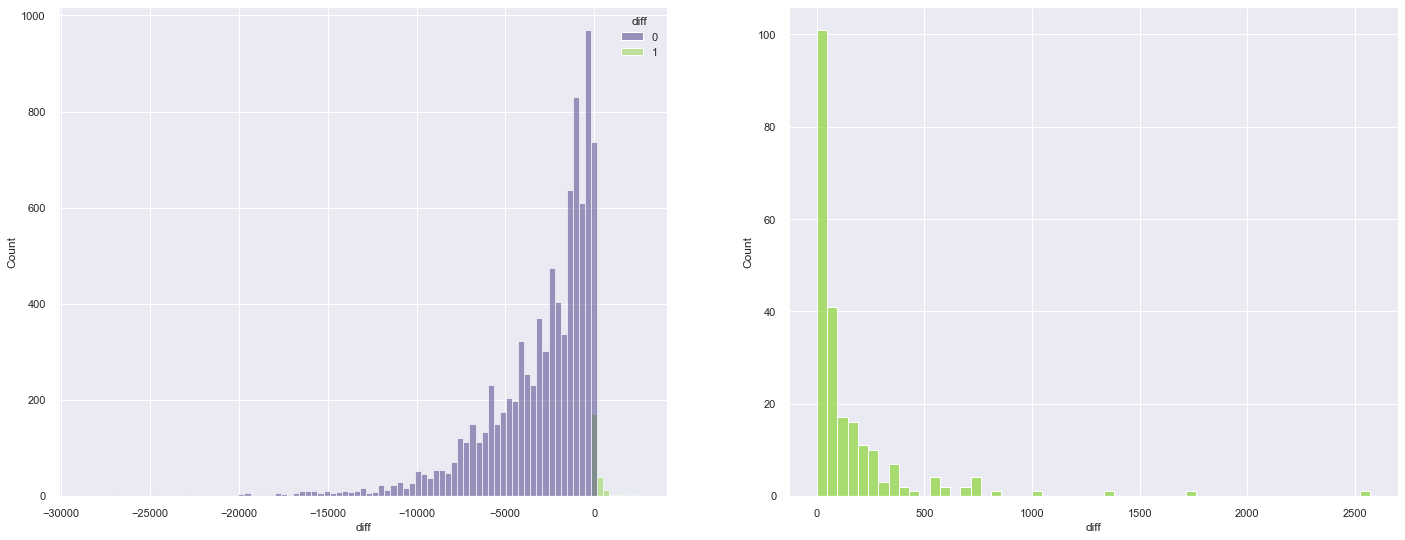

In [26]:
# Histplot of cases that have balance over credit_limit
plt.subplot(1,2,1)
sns.histplot(x=df4['diff'],hue=df4['diff'].map(lambda x: 1 if x>0 else 0),palette = sns.set_palette([viridis0,viridis2]));

plt.subplot(1,2,2)
sns.histplot(df4[df4['diff']>0]['diff'],color=viridis2);

In [27]:
df4.drop('diff',axis=1,inplace=True)

### 4.1.2. balance_frequency

In [28]:
n = df4[df4['balance_frequency']==1].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database are classified with balance_frequency = 1, which is the maximum value.')

6188 customers that represents 69.39% from database are classified with balance_frequency = 1, which is the maximum value.


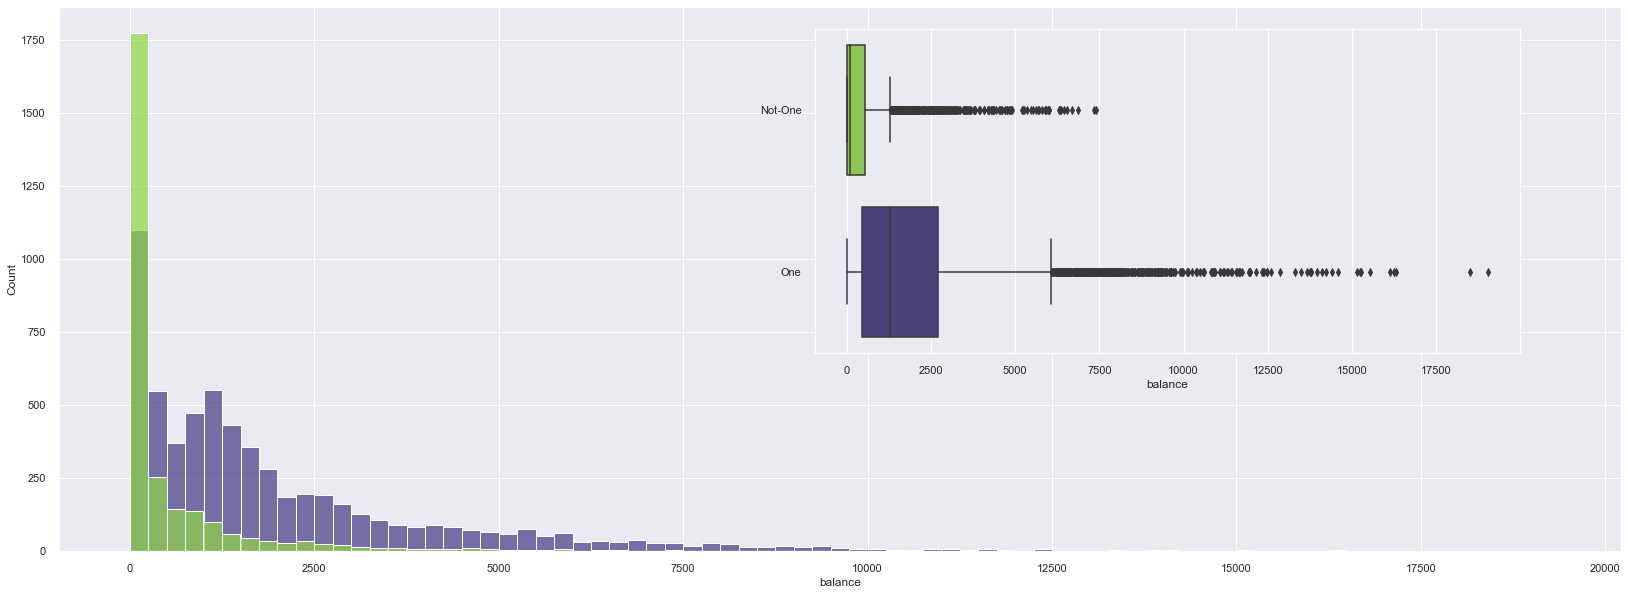

In [29]:
fig = plt.figure(figsize=(28,10))

sns.histplot(df4[df4['balance_frequency']==1]['balance'],color=viridis0,binwidth=250,alpha=.7);
sns.histplot(df4[df4['balance_frequency']!=1]['balance'],color=viridis2,binwidth=250,alpha=.7);

ax2 = fig.add_axes([.5,.4,.35,.45])

df4['bf1'] = df4['balance_frequency'].apply(lambda x: 'One' if x==1 else 'Not-One')
sns.boxplot(data=df4,x='balance',y='bf1',palette=sns.set_palette([viridis2,viridis0]),ax=ax2);
ax2.set_ylabel(' ');

In [30]:
df4.drop('bf1',axis=1,inplace=True)
sns.set_palette([viridis0,viridis1,viridis2])

### 4.1.3. purchases

In [31]:
n = df4[df4['purchases']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database spent $0 in the last 6 months.')

2036 customers that represents 22.83% from database spent $0 in the last 6 months.


In [32]:
n1 = df4['purchases'].quantile(.99)
n2 = df4['purchases'].max()
print(f'Only 1% of  the customers from the database spent more than ${round(n1,2)}, being ${n2} the maximum amount spent.')

Only 1% of  the customers from the database spent more than $8997.13, being $49039.57 the maximum amount spent.


In [33]:
purchases_gb = df4.groupby(df4['purchases'].apply(lambda x: 'High' if x>df4['purchases'].quantile(.99) else
                                                            'Zero' if x==0 else
                                                            'Between'))

In [34]:
purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

purchases                        Between       High  Zero
purchases              min      0.010000   9007.670   0.0
                       mean  1112.313210  15637.641   0.0
                       max   8945.670000  49039.570   0.0
oneoff_purchases       min      0.000000      0.000   0.0
                       mean   634.965458  10930.790   0.0
                       max   8945.670000  40761.250   0.0
installments_purchases min      0.000000      0.000   0.0
                       mean   477.347752   4706.851   0.0
                       max   8391.550000  22500.000   0.0

In [35]:
purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases                               Between      High  Zero
purchases_frequency              min   0.083333  0.166667   0.0
                                 mean  0.632255  0.905370   0.0
                                 max   1.000000  1.000000   0.0
oneoff_purchases_frequency       min   0.000000  0.000000   0.0
                                 mean  0.256397  0.756953   0.0
                                 max   1.000000  1.000000   0.0
purchases_installments_frequency min   0.000000  0.000000   0.0
                                 mean  0.468911  0.738434   0.0
                                 max   1.000000  1.000000   0.0

In [36]:
purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

purchases               Between         High  Zero
purchases_trx min      1.000000     3.000000   0.0
              mean    17.740135   120.555556   0.0
              max    309.000000   358.000000   0.0
purchases_avg min      0.010000    37.340714   0.0
              mean    92.504537   345.462596   0.0
              max   2900.000000  5981.666667   0.0

### 4.1.4. oneoff_purchases 

In [37]:
n = df4[df4['oneoff_purchases']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database spent $0 on one-off in the last 6 months.')

4281 customers that represents 48.0% from database spent $0 on one-off in the last 6 months.


In [38]:
n1 = df4['oneoff_purchases'].quantile(.99)
n2 = df4['oneoff_purchases'].max()
print(f'Only 1% of  the customers from the database spent more than ${round(n1,2)} on one-off, being ${n2} the maximum amount spent.')

Only 1% of  the customers from the database spent more than $6697.2 on one-off, being $40761.25 the maximum amount spent.


In [39]:
one_off_purchases_gb = df4.groupby(df4['oneoff_purchases'].apply(lambda x: 'High' if x>df4['oneoff_purchases'].quantile(.99) else
                                                                           'Zero' if x==0 else
                                                                           'Between'))

In [42]:
one_off_purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

oneoff_purchases                  Between          High          Zero
purchases              min       0.010000   6814.470000      0.000000
                       mean   1417.972874  14577.338889    280.947407
                       max   15108.470000  49039.570000  22500.000000
oneoff_purchases       min       0.010000   6701.080000      0.000000
                       mean    922.293921  12253.178111      0.000000
                       max    6678.260000  40761.250000      0.000000
installments_purchases min       0.000000      0.000000      0.000000
                       mean    495.678953   2324.160778    280.947407
                       max   12738.470000  15497.190000  22500.000000

In [43]:
one_off_purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

oneoff_purchases                        Between      High      Zero
purchases_frequency              min   0.083333  0.166667  0.000000
                                 mean  0.601257  0.898721  0.364625
                                 max   1.000000  1.000000  1.000000
oneoff_purchases_frequency       min   0.083333  0.166667  0.000000
                                 mean  0.381199  0.847357  0.000000
                                 max   1.000000  1.000000  0.000000
purchases_installments_frequency min   0.000000  0.000000  0.000000
                                 mean  0.378122  0.585909  0.345538
                                 max   1.000000  1.000000  1.000000

In [44]:
one_off_purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

oneoff_purchases        Between         High         Zero
purchases_trx min      1.000000     3.000000     0.000000
              mean    21.109523    96.833333     6.223079
              max    309.000000   358.000000   347.000000
purchases_avg min      0.010000    38.653629     0.000000
              mean   112.457915   323.059451    27.788123
              max   2900.000000  5981.666667  1875.000000

### 4.1.5. installments_purchases

In [45]:
n = df4[df4['installments_purchases']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database spent $0 on installments in the last 6 months.')

3902 customers that represents 43.75% from database spent $0 on installments in the last 6 months.


In [46]:
n1 = df4['installments_purchases'].quantile(.99)
n2 = df4['installments_purchases'].max()
print(f'Only 1% of  the customers from the database spent more than ${round(n1,2)} on installments, being ${n2} the maximum amount spent.')

Only 1% of  the customers from the database spent more than $3882.18 on installments, being $22500.0 the maximum amount spent.


In [47]:
installments_purchases_gb = df4.groupby(df4['installments_purchases'].apply(lambda x: 'High' if x>df4['installments_purchases'].quantile(.99) else
                                                                                      'Zero' if x==0 else
                                                                                      'Between'))

In [48]:
installments_purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

installments_purchases            Between          High          Zero
purchases              min       4.440000   3927.120000      0.000000
                       mean   1306.282873  11719.895556    377.416448
                       max   41050.400000  49039.570000  22101.780000
oneoff_purchases       min       0.000000      0.000000      0.000000
                       mean    680.917503   5217.532111    377.416448
                       max   40624.060000  40761.250000  22101.780000
installments_purchases min       1.950000   3885.450000      0.000000
                       mean    625.365369   6502.363444      0.000000
                       max    3866.190000  22500.000000      0.000000

In [49]:
installments_purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

installments_purchases                  Between      High      Zero
purchases_frequency              min   0.083333  0.333333  0.000000
                                 mean  0.749303  0.944175  0.153695
                                 max   1.000000  1.000000  1.000000
oneoff_purchases_frequency       min   0.000000  0.000000  0.000000
                                 mean  0.235866  0.534983  0.153652
                                 max   1.000000  1.000000  1.000000
purchases_installments_frequency min   0.083333  0.166667  0.000000
                                 mean  0.643528  0.903165  0.000000
                                 max   1.000000  1.000000  0.000000

In [50]:
installments_purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

installments_purchases      Between         High         Zero
purchases_trx min          1.000000     5.000000     0.000000
              mean        22.127081   100.544444     3.406971
              max        344.000000   358.000000   309.000000
purchases_avg min          1.000000    37.340714     0.000000
              mean        63.285402   214.710252    84.140090
              max       1500.000000  2523.438000  5981.666667

### 4.1.6. cash_advance

#### Outlier

In [51]:
# Cust_id=2159 appears to be an outlier
df4['cash_advance'].sort_values(ascending=False).head()

2159    47137.21176
1059    29282.10915
71      27296.48576
7254    26268.69989
7645    26194.04954
Name: cash_advance, dtype: float64

In [52]:
df4.sort_values('cash_advance',ascending=False).head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchases_avg,cash_advance_avg
2159,12226,10905.053810,1.000000,431.93,133.50,298.43,47137.21176,0.583333,0.250000,0.500000,1.000000,123,21,19600.0,39048.59762,5394.173671,0.000000,12,20.568095,383.229364
1059,11094,8823.284205,1.000000,3719.00,2293.18,1425.82,29282.10915,1.000000,0.750000,1.000000,0.416667,26,61,15500.0,28150.97869,7321.639932,0.083333,12,60.967213,1126.234967
71,10074,2990.422186,0.909091,4523.27,1664.09,2859.18,27296.48576,0.666667,0.500000,0.583333,0.833333,27,33,7000.0,28232.69446,1107.030803,0.454545,12,137.068788,1010.980954
7254,17450,4530.205197,1.000000,1750.66,643.18,1107.48,26268.69989,1.000000,0.333333,1.000000,0.583333,10,36,8500.0,25203.91336,1366.869273,0.250000,12,48.629444,2626.869989
7645,17851,7081.171387,1.000000,0.00,0.00,0.00,26194.04954,0.000000,0.000000,0.000000,0.909091,69,0,9000.0,20191.30770,1926.017588,0.222222,11,0.000000,379.623906


In [53]:
df4.sort_values('cash_advance_trx',ascending=False)['cash_advance'].head()

2159    47137.211760
542      5406.459348
8315    10458.978150
3545     9968.184827
1913     5603.126858
Name: cash_advance, dtype: float64

In [54]:
df4.sort_values('cash_advance_avg',ascending=False)['cash_advance'].head()

3908    14836.451410
2487    10590.411130
2682     9798.167329
637      9671.336737
2815     9553.955906
Name: cash_advance, dtype: float64

Cust_id=2159 performed the maximum cash_advance value found in the last 6 months, but it is still not in the top 5 cash_advance_avg list, furthermore its value is too far away from being on the list.
Because of this, it will be treated as a outlier

#### GroupBy Analysis

In [55]:
df4.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure', 'purchases_avg',
       'cash_advance_avg'],
      dtype='object')

In [56]:
n = df4[df4['cash_advance']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% did not perform any cash_advance in the last 6 months.')

4612 customers that represents 51.72% did not perform any cash_advance in the last 6 months.


In [57]:
n1 = df4['cash_advance'].quantile(.99)
n2 = df4['cash_advance'].max()
print(f'Only 1% of  the customers from the database perform more than ${round(n1,2)} on cash advance, being ${n2} the maximum amount.')

Only 1% of  the customers from the database perform more than $9593.49 on cash advance, being $47137.21176 the maximum amount.


In [58]:
cash_advance_gb = df4.groupby(df4['cash_advance'].apply(lambda x: 'High' if x>df4['cash_advance'].quantile(.99) else
                                                                  'Zero' if x==0 else
                                                                  'Between'))

In [59]:
cash_advance_gb[['cash_advance','cash_advance_frequency','cash_advance_trx','cash_advance_avg']].agg(['min','mean','max']).T

cash_advance                     Between          High  Zero
cash_advance           min     14.222216   9596.316702   0.0
                       mean  1773.164446  13859.316198   0.0
                       max   9579.677222  47137.211760   0.0
cash_advance_frequency min      0.083333      0.083333   0.0
                       mean     0.272039      0.571094   0.0
                       max      1.000000      1.000000   0.0
cash_advance_trx       min      1.000000      1.000000   0.0
                       mean     6.311907     25.266667   0.0
                       max    123.000000    123.000000   0.0
cash_advance_avg       min     14.222216     85.032343   0.0
                       mean   412.748882   1402.527239   0.0
                       max   9553.955906  14836.451410   0.0

### 4.1.7 purchases_frequency

In [60]:
n0 = df4[df4['purchases_frequency']==0].shape[0]
n1 = df4[df4['purchases_frequency']==1].shape[0]
print(f'{n0} customers were classified with purchases_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')
print(f'{n1} customers were classified with purchases_frequency=1, which is the maximum value, this customers represents {round(n1/df4.shape[0]*100,2)}% of the database.')

2036 customers were classified with purchases_frequency=0, which is the minimum value, this customers represents 22.83% of the database.
2173 customers were classified with purchases_frequency=1, which is the maximum value, this customers represents 24.37% of the database.


In [61]:
purc_freq_gb = df4.groupby(df4['purchases_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                      'One' if x==1 else
                                                                      'Between'))

In [62]:
purc_freq_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_frequency                     Between       One  Zero
purchases_frequency              min   0.083333  1.000000   0.0
                                 mean  0.467777  1.000000   0.0
                                 max   0.916667  1.000000   0.0
oneoff_purchases_frequency       min   0.000000  0.000000   0.0
                                 mean  0.200699  0.397829   0.0
                                 max   1.000000  1.000000   0.0
purchases_installments_frequency min   0.000000  0.000000   0.0
                                 mean  0.298310  0.849774   0.0
                                 max   1.000000  1.000000   0.0

In [63]:
purc_freq_gb[['purchases','oneoff_purchases','installments_purchases','purchases_trx']].agg(['min','mean','max']).T

purchases_frequency               Between           One  Zero
purchases              min       0.010000      8.400000   0.0
                       mean    870.787874   2237.311970   0.0
                       max   41050.400000  49039.570000   0.0
oneoff_purchases       min       0.000000      0.000000   0.0
                       mean    565.629382   1211.646447   0.0
                       max   40624.060000  40761.250000   0.0
installments_purchases min       0.000000      0.000000   0.0
                       mean    305.158492   1025.665522   0.0
                       max   22500.000000  15497.190000   0.0
purchases_trx          min       1.000000      6.000000   0.0
                       mean     10.579316     37.516337   0.0
                       max     309.000000    358.000000   0.0

### 4.1.8. oneoff_purchases_frequency

In [64]:
n0 = df4[df4['oneoff_purchases_frequency']==0].shape[0]
print(f'{n0} customers were classified with oneoff_purchases_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')

4281 customers were classified with oneoff_purchases_frequency=0, which is the minimum value, this customers represents 48.0% of the database.


In [65]:
oo_purc_freq_gb = df4.groupby(df4['oneoff_purchases_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                                'Not Zero'))

In [66]:
oo_purc_freq_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

oneoff_purchases_frequency             Not Zero      Zero
purchases_frequency              min   0.083333  0.000000
                                 mean  0.607030  0.364625
                                 max   1.000000  1.000000
oneoff_purchases_frequency       min   0.083333  0.000000
                                 mean  0.390247  0.000000
                                 max   1.000000  0.000000
purchases_installments_frequency min   0.000000  0.000000
                                 mean  0.382155  0.345538
                                 max   1.000000  1.000000

In [67]:
oo_purc_freq_gb[['purchases','oneoff_purchases','installments_purchases','purchases_trx']].agg(['min','mean','max']).T

oneoff_purchases_frequency       Not Zero          Zero
purchases              min       0.010000      0.000000
                       mean   1673.384335    280.947407
                       max   49039.570000  22500.000000
oneoff_purchases       min       0.010000      0.000000
                       mean   1142.216194      0.000000
                       max   40761.250000      0.000000
installments_purchases min       0.000000      0.000000
                       mean    531.168141    280.947407
                       max   15497.190000  22500.000000
purchases_trx          min       1.000000      0.000000
                       mean     22.579254      6.223079
                       max     358.000000    347.000000

### 4.1.9. purchases_installments_frequency

In [68]:
n0 = df4[df4['purchases_installments_frequency']==0].shape[0]
print(f'{n0} customers were classified with purchases_installments_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')

3902 customers were classified with purchases_installments_frequency=0, which is the minimum value, this customers represents 43.75% of the database.


In [69]:
ins_purc_freq_gb = df4.groupby(df4['purchases_installments_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                                'Not Zero'))

In [70]:
ins_purc_freq_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_installments_frequency       Not Zero      Zero
purchases_frequency              min   0.083333  0.000000
                                 mean  0.752800  0.153695
                                 max   1.000000  1.000000
oneoff_purchases_frequency       min   0.000000  0.000000
                                 mean  0.241233  0.153652
                                 max   1.000000  1.000000
purchases_installments_frequency min   0.083333  0.000000
                                 mean  0.648186  0.000000
                                 max   1.000000  0.000000

In [71]:
ins_purc_freq_gb[['purchases','oneoff_purchases','installments_purchases','purchases_trx']].agg(['min','mean','max']).T

purchases_installments_frequency      Not Zero          Zero
purchases              min            4.440000      0.000000
                       mean        1493.129990    377.416448
                       max        49039.570000  22101.780000
oneoff_purchases       min            0.000000      0.000000
                       mean         762.316091    377.416448
                       max        40761.250000  22101.780000
installments_purchases min            1.950000      0.000000
                       mean         730.813900      0.000000
                       max        22500.000000      0.000000
purchases_trx          min            1.000000      0.000000
                       mean          23.534091      3.406971
                       max          358.000000    309.000000

### 4.1.10. cash_advance_frequency

In [72]:
n0 = df4[df4['cash_advance_frequency']==0].shape[0]
print(f'{n0} customers were classified with cash_advance_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')

4612 customers were classified with cash_advance_frequency=0, which is the minimum value, this customers represents 51.72% of the database.


In [73]:
cash_adv_freq_gb = df4.groupby(df4['cash_advance_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                             'Not Zero'))

In [74]:
cash_adv_freq_gb[['balance','cash_advance','cash_advance_trx','cash_advance_avg']].agg(['min','mean','max']).T

cash_advance_frequency      Not Zero          Zero
balance          min        0.000000      0.000000
                 mean    2386.856980    793.301553
                 max    16304.889250  19043.138560
cash_advance     min       14.222216      0.000000
                 mean    2025.777929      0.000000
                 max    47137.211760      0.000000
cash_advance_trx min        1.000000      0.000000
                 mean       6.708082      0.000000
                 max      123.000000      0.000000
cash_advance_avg min       14.222216      0.000000
                 mean     433.436307      0.000000
                 max    14836.451410      0.000000

### 4.1.11. cash_advance_trx

In [75]:
n = df4[df4['cash_advance_trx']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database performed 0 cash advance transactions in the last 6 months.')

4612 customers that represents 51.72% from database performed 0 cash advance transactions in the last 6 months.


In [76]:
n1 = df4['cash_advance_trx'].quantile(.99)
n2 = df4['cash_advance_trx'].max()
print(f'Only 1% of  the customers from the database performed more than ${round(n1,2)} cash advance transactions, being ${n2} the maximum number of cash advance transactions made.')

Only 1% of  the customers from the database performed more than $29.0 cash advance transactions, being $123 the maximum number of cash advance transactions made.


In [77]:
cash_adv_trx_gb = df4.groupby(df4['cash_advance_trx'].apply(lambda x: 'High' if x>df4['cash_advance_trx'].quantile(.99) else
                                                                      'Zero' if x==0 else
                                                                      'Between'))

In [78]:
cash_adv_trx_gb[['balance','cash_advance','cash_advance_frequency','cash_advance_avg']].agg(['min','mean','max']).T

cash_advance_trx                  Between          High          Zero
balance                min       0.000000    168.600813      0.000000
                       mean   2346.694711   4289.826510    793.301553
                       max   16304.889250  14581.459140  19043.138560
cash_advance           min      14.222216   1244.774872      0.000000
                       mean   1905.548913   7722.471861      0.000000
                       max   29282.109150  47137.211760      0.000000
cash_advance_frequency min       0.083333      0.166667      0.000000
                       mean      0.267950      0.768200      0.000000
                       max       1.000000      1.000000      0.000000
cash_advance_avg       min      14.222216     40.154028      0.000000
                       mean    438.839999    177.398444      0.000000
                       max   14836.451410    755.525950      0.000000

### 4.1.12. purchases_trx

In [79]:
n = df4[df4['purchases_trx']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database performed 0 purchases transactions in the last 6 months.')

2036 customers that represents 22.83% from database performed 0 purchases transactions in the last 6 months.


In [80]:
n1 = df4['purchases_trx'].quantile(.99)
n2 = df4['purchases_trx'].max()
print(f'Only 1% of  the customers from the database performed more than ${round(n1,2)} purchases transactions, being ${n2} the maximum number of purchases transactions made.')

Only 1% of  the customers from the database performed more than $116.83 purchases transactions, being $358 the maximum number of purchases transactions made.


In [81]:
purchases_trx_gb = df4.groupby(df4['purchases_trx'].apply(lambda x: 'High' if x>df4['purchases_trx'].quantile(.99) else
                                                                    'Zero' if x==0 else
                                                                    'Between'))

In [82]:
purchases_trx_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

purchases_trx                     Between          High  Zero
purchases              min       0.010000    900.870000   0.0
                       mean   1189.012571   9849.395889   0.0
                       max   49039.570000  41050.400000   0.0
oneoff_purchases       min       0.000000      0.000000   0.0
                       mean    698.746294   6117.462889   0.0
                       max   40761.250000  40624.060000   0.0
installments_purchases min       0.000000      0.000000   0.0
                       mean    490.266277   3731.933000   0.0
                       max   22500.000000  15497.190000   0.0

In [83]:
purchases_trx_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_trx                           Between      High  Zero
purchases_frequency              min   0.083333  0.363636   0.0
                                 mean  0.631279  0.979040   0.0
                                 max   1.000000  1.000000   0.0
oneoff_purchases_frequency       min   0.000000  0.000000   0.0
                                 mean  0.256768  0.728956   0.0
                                 max   1.000000  1.000000   0.0
purchases_installments_frequency min   0.000000  0.000000   0.0
                                 mean  0.466833  0.895286   0.0
                                 max   1.000000  1.000000   0.0

### 4.1.13. purchases_avg

In [84]:
n = df4[df4['purchases_avg']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database has average purchases equal to 0 in the last 6 months.')

2036 customers that represents 22.83% from database has average purchases equal to 0 in the last 6 months.


In [85]:
n1 = df4['purchases_avg'].quantile(.99)
n2 = df4['purchases_avg'].max()
print(f'Only 1% of  the customers from the database has average purchases greater than ${round(n1,2)}, being ${round(n2,2)} the maximum average purchases.')

Only 1% of  the customers from the database has average purchases greater than $761.38, being $5981.67 the maximum average purchases.


In [86]:
avg_purchases_gb = df4.groupby(df4['purchases_avg'].apply(lambda x: 'High Spenders' if x>df4['purchases_avg'].quantile(.99) else
                                                                    'Zero' if x==0 else
                                                                    'Low Spenders'))

In [87]:
avg_purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

purchases_avg                High Spenders  Low Spenders  Zero
purchases              min      763.710000      0.010000   0.0
                       mean    3069.047889   1278.858171   0.0
                       max    26784.620000  49039.570000   0.0
oneoff_purchases       min        0.000000      0.000000   0.0
                       mean    2424.782778    747.677568   0.0
                       max    26514.320000  40761.250000   0.0
installments_purchases min        0.000000      0.000000   0.0
                       mean     644.265111    531.180604   0.0
                       max    22500.000000  15497.190000   0.0

In [88]:
avg_purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_avg                          High Spenders  Low Spenders  Zero
purchases_frequency              min        0.083333      0.083333   0.0
                                 mean       0.156818      0.642174   0.0
                                 max        0.750000      1.000000   0.0
oneoff_purchases_frequency       min        0.000000      0.000000   0.0
                                 mean       0.129967      0.264705   0.0
                                 max        0.750000      1.000000   0.0
purchases_installments_frequency min        0.000000      0.000000   0.0
                                 mean       0.025926      0.478352   0.0
                                 max        0.750000      1.000000   0.0

In [89]:
avg_purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

purchases_avg       High Spenders  Low Spenders  Zero
purchases_trx min        1.000000      1.000000   0.0
              mean       2.466667     19.304918   0.0
              max       33.000000    358.000000   0.0
purchases_avg min      763.710000      0.010000   0.0
              mean    1267.341731     80.288824   0.0
              max     5981.666667    750.000000   0.0

### 4.1.14. cash_advance_avg

In [90]:
n = df4[df4['cash_advance_avg']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database has average cash advance equal to 0 in the last 6 months.')

4612 customers that represents 51.72% from database has average cash advance equal to 0 in the last 6 months.


In [91]:
n1 = df4['cash_advance_avg'].quantile(.99)
n2 = df4['cash_advance_avg'].max()
print(f'Only 1% of  the customers from the database has average cash advance greater than ${round(n1,2)}, being ${round(n2,2)} the maximum average cash advance.')

Only 1% of  the customers from the database has average cash advance greater than $1909.51, being $14836.45 the maximum average cash advance.


In [92]:
avg_cash_adv_gb = df4.groupby(df4['cash_advance_avg'].apply(lambda x: 'High Taker' if x>df4['cash_advance_avg'].quantile(.99) else
                                                                      'Zero' if x==0 else
                                                                      'Low Taker'))

In [93]:
avg_cash_adv_gb[['cash_advance','cash_advance_frequency','cash_advance_trx']].agg(['min','mean','max']).T

cash_advance_avg               High Taker     Low Taker  Zero
cash_advance           min    1909.684135     14.222216   0.0
                       mean   5275.877976   1956.397235   0.0
                       max   26268.699890  47137.211760   0.0
cash_advance_frequency min       0.083333      0.083333   0.0
                       mean      0.123097      0.281603   0.0
                       max       0.583333      1.000000   0.0
cash_advance_trx       min       1.000000      1.000000   0.0
                       mean      1.500000      6.819260   0.0
                       max      10.000000    123.000000   0.0

## 4.2. Data Space Study: MinMaxScaler

In [93]:
df42 = df_ref.drop('cust_id',axis=1).copy()

In [94]:
mm = pp.MinMaxScaler()

In [95]:
for feature in df42.columns:
    df42[feature] = mm.fit_transform(df42[[feature]])
    
X = df42.copy()

In [96]:
df42.describe().T

,count,mean,std,min,25%,50%,75%,max
oneoff_purchases,8918.0,0.014570,0.040781,0.0,0.000000,0.000957,0.014282,1.0
installments_purchases,8918.0,0.018269,0.040161,0.0,0.000000,0.003972,0.020772,1.0
cash_advance,8918.0,0.020751,0.044503,0.0,0.000000,0.000000,0.023621,1.0
oneoff_purchases_frequency,8918.0,0.202913,0.298672,0.0,0.000000,0.083333,0.300000,1.0
purchases_installments_frequency,8918.0,0.364578,0.397465,0.0,0.000000,0.166667,0.750000,1.0
cash_advance_frequency,8918.0,0.134371,0.197766,0.0,0.000000,0.000000,0.222222,1.0
purchases_trx,8918.0,0.041139,0.069498,0.0,0.002793,0.019553,0.047486,1.0
cash_advance_trx,8918.0,0.026333,0.055409,0.0,0.000000,0.000000,0.032520,1.0
purchases_avg,8918.0,0.012361,0.026857,0.0,0.002007,0.006934,0.013176,1.0
cash_advance_avg,8918.0,0.014106,0.036158,0.0,0.000000,0.000000,0.016682,1.0


### 4.2.1. PCA

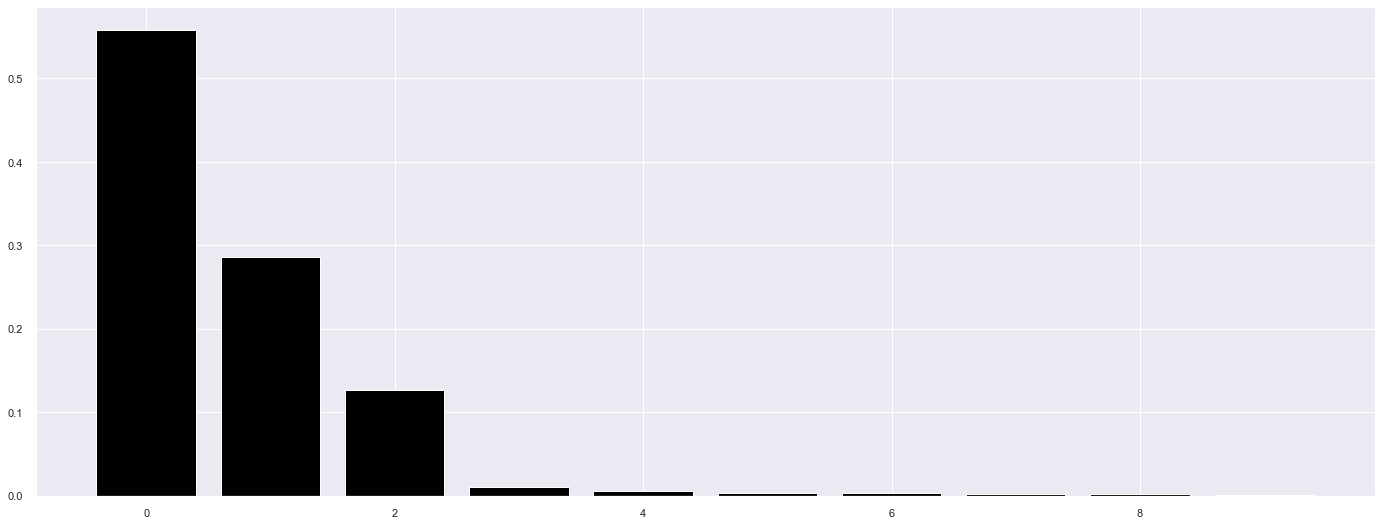

In [97]:
pca = dd.PCA( n_components=X.shape[1])

principal_components = pca.fit_transform( X )

# plot explained variable
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_ratio_,color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

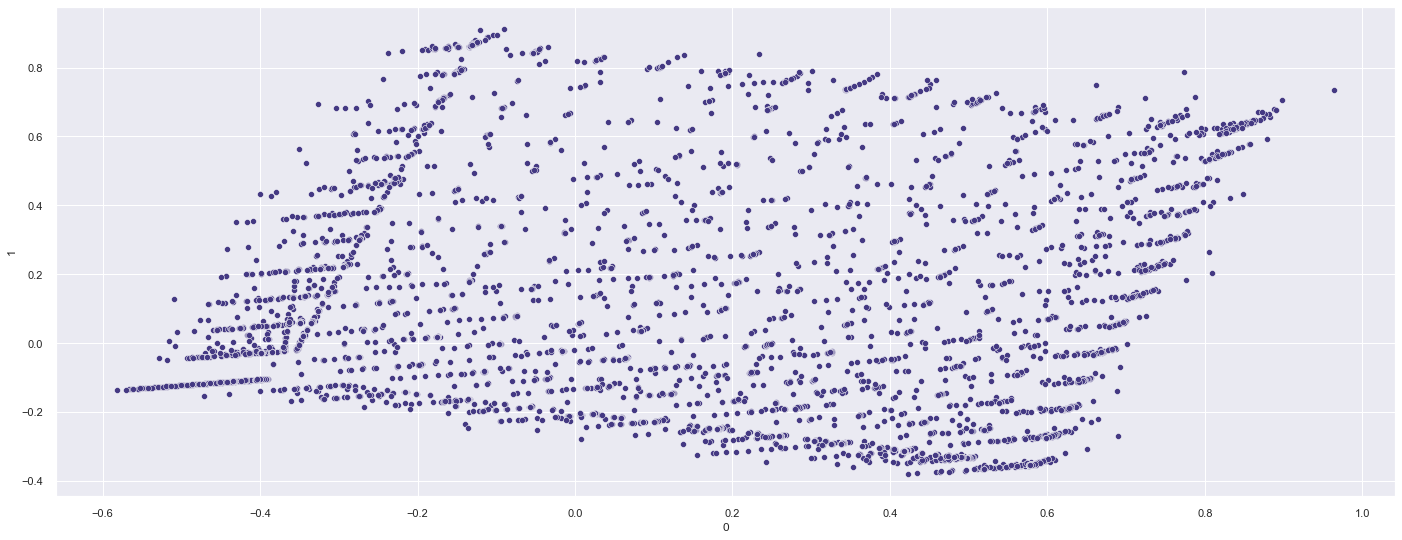

In [98]:
sns.scatterplot(x=0,y=1,data=df_pca);

### 4.2.2. UMAP

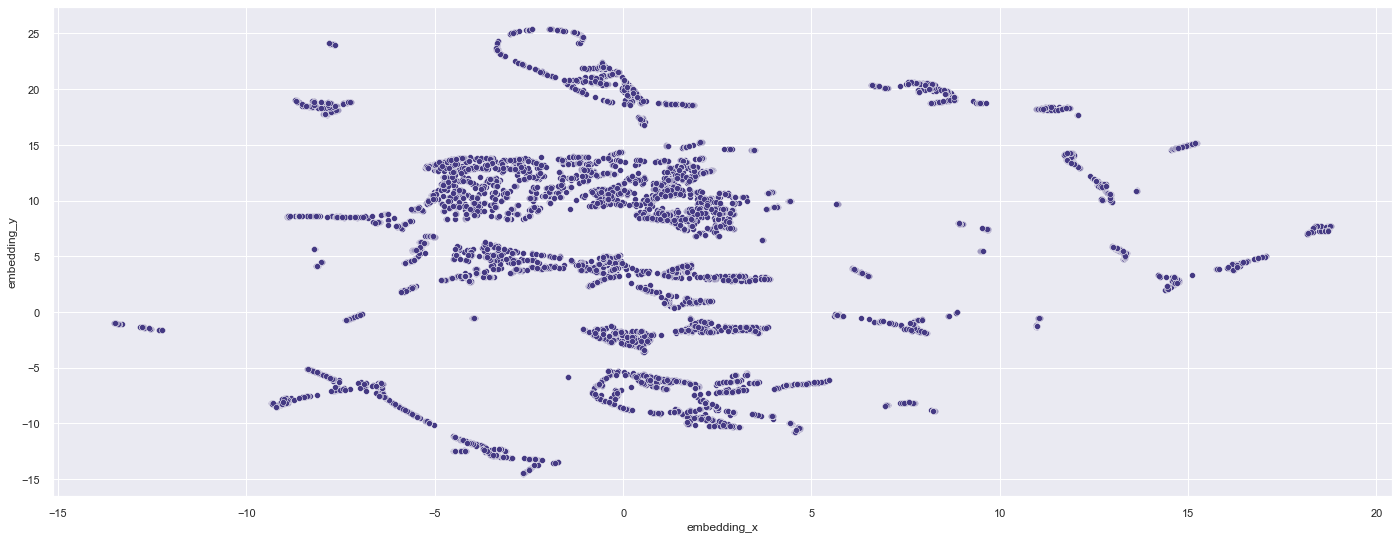

In [99]:
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame(embedding[:,0]).rename(columns={0:'embedding_x'})
df_umap['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x',
                y = 'embedding_y',
                data = df_umap);

### 4.2.3. t-SNE

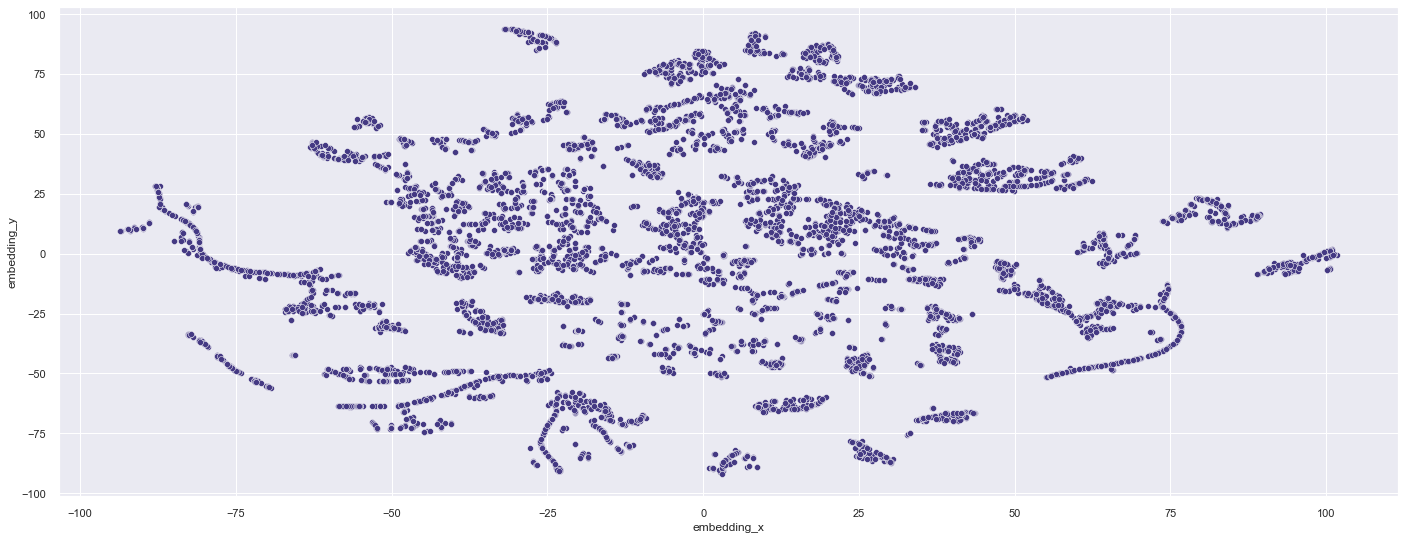

In [100]:
reducer = TSNE(n_components=2,
               n_jobs=-1,
               random_state=101)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame(embedding[:,0]).rename(columns={0:'embedding_x'})
df_tsne['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x',
                y = 'embedding_y',
                data = df_tsne);

### 4.2.4. Tree-Based Embedding

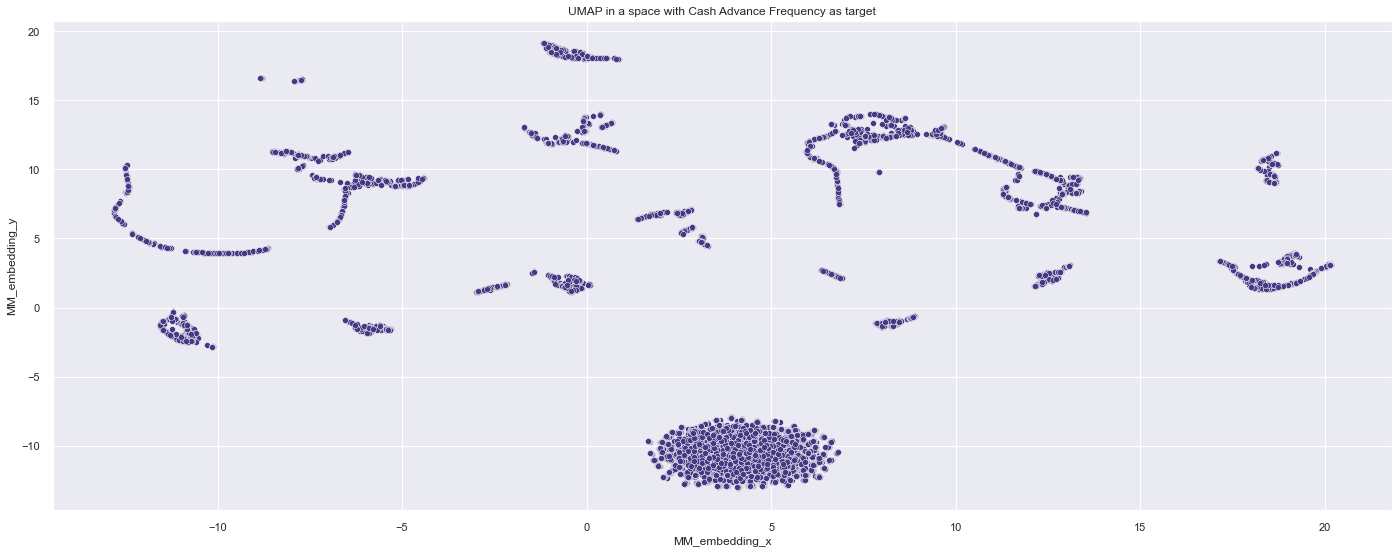

In [100]:
# training dataset
X = df_ref.drop(['cust_id','cash_advance_frequency'],axis=1)
y= df_ref['cash_advance_frequency']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame(embedding[:,0]).rename(columns={0:'MM_embedding_x'})       
df_tree['MM_embedding_y'] = embedding[:,1]

# plotting
sns.scatterplot(x = 'MM_embedding_x',
                y = 'MM_embedding_y',
                data = df_tree);
plt.title('UMAP in a space with Cash Advance Frequency as target');

## 4.3. Data Space Study: StandardScaler

In [102]:
df43 = df_ref.drop('cust_id',axis=1).copy()

In [103]:
ss = pp.StandardScaler()

In [104]:
for feature in df42.columns:
    df43[feature] = ss.fit_transform(df43[[feature]])
    
X = df43.copy()

In [105]:
df43.describe().T

,count,mean,std,min,25%,50%,75%,max
oneoff_purchases,8918.0,5.682934e-15,1.000056,-0.357300,-0.357300,-0.333837,-0.007064,24.165044
installments_purchases,8918.0,-6.728564e-16,1.000056,-0.454915,-0.454915,-0.356014,0.062339,24.446016
cash_advance,8918.0,2.964431e-15,1.000056,-0.466309,-0.466309,-0.466309,0.064508,22.005548
oneoff_purchases_frequency,8918.0,5.107126e-15,1.000056,-0.679421,-0.679421,-0.400393,0.325082,2.668922
purchases_installments_frequency,8918.0,1.455664e-15,1.000056,-0.917309,-0.917309,-0.497961,0.969757,1.598779
cash_advance_frequency,8918.0,1.684407e-15,1.000056,-0.679479,-0.679479,-0.679479,0.444243,4.377278
purchases_trx,8918.0,-9.497959e-16,1.000056,-0.591972,-0.551777,-0.310609,0.091337,13.797705
cash_advance_trx,8918.0,1.483457e-15,1.000056,-0.475274,-0.475274,-0.475274,0.111673,17.573362
purchases_avg,8918.0,2.996438e-16,1.000056,-0.460268,-0.385553,-0.202085,0.030358,36.775773
cash_advance_avg,8918.0,-1.347294e-15,1.000056,-0.390140,-0.390140,-0.390140,0.071240,27.267747


### 4.3.1. PCA

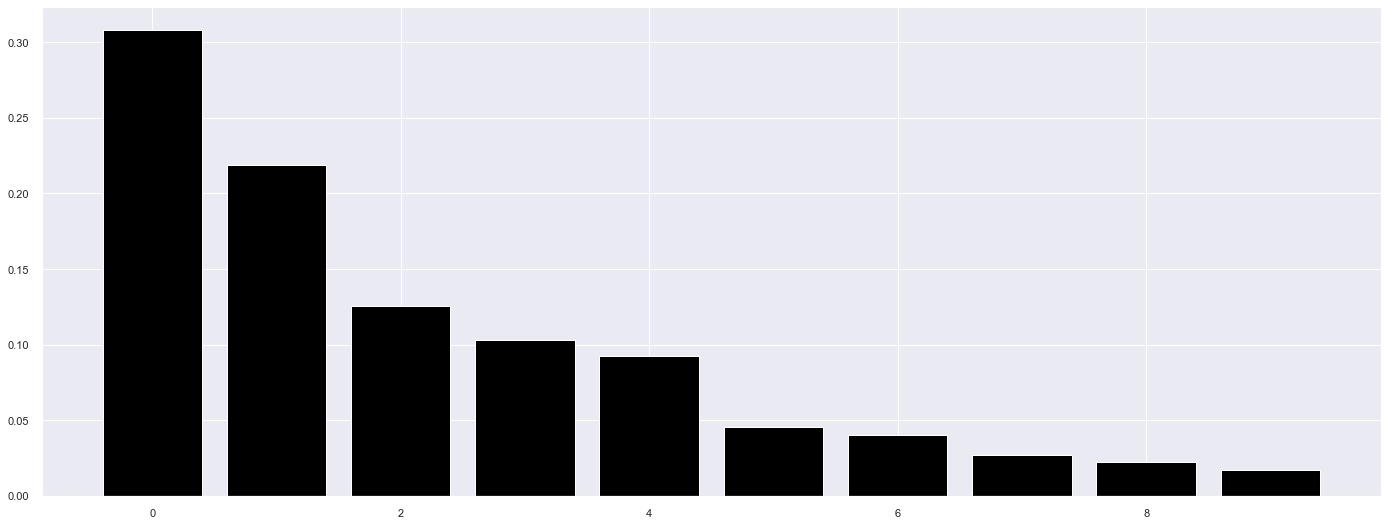

In [106]:
pca = dd.PCA( n_components=X.shape[1])

principal_components = pca.fit_transform( X )

# plot explained variable
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_ratio_,color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

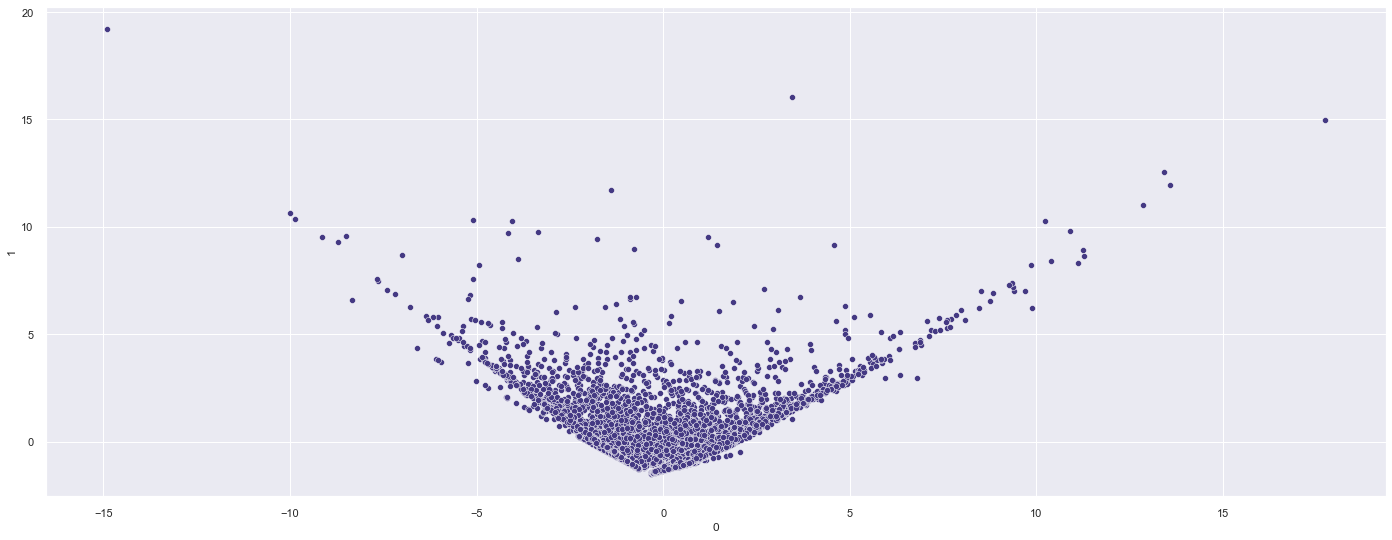

In [107]:
sns.scatterplot(x=0,y=1,data=df_pca);

### 4.3.2. UMAP

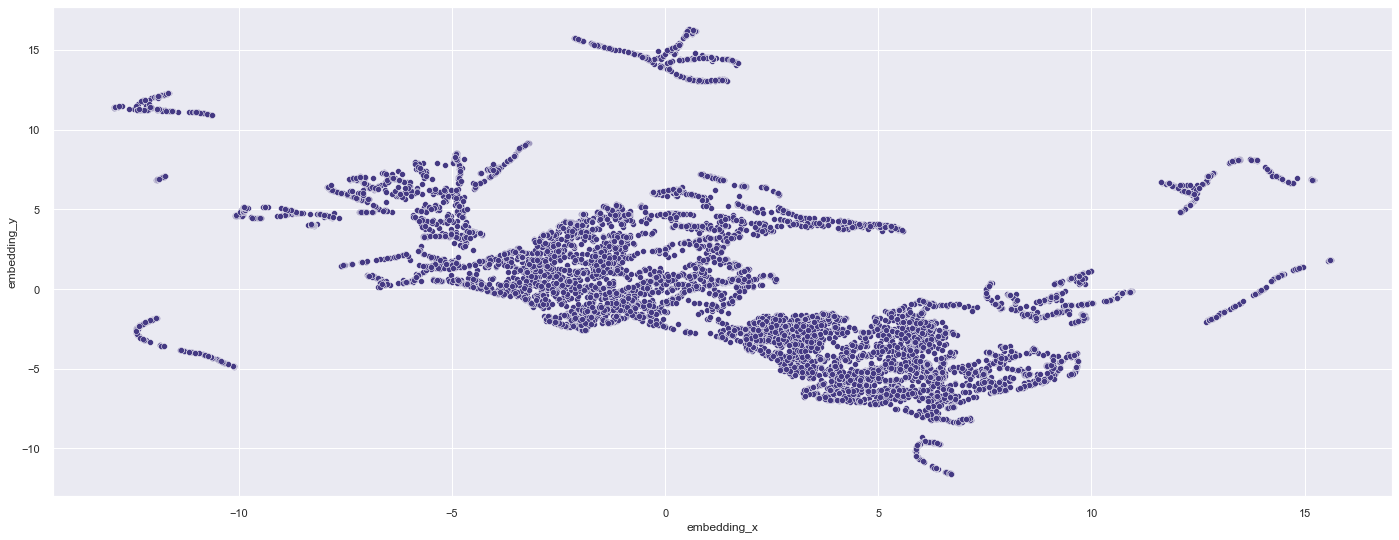

In [108]:
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame(embedding[:,0]).rename(columns={0:'embedding_x'})
df_umap['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x',
                y = 'embedding_y',
                data = df_umap);

### 4.3.3. t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

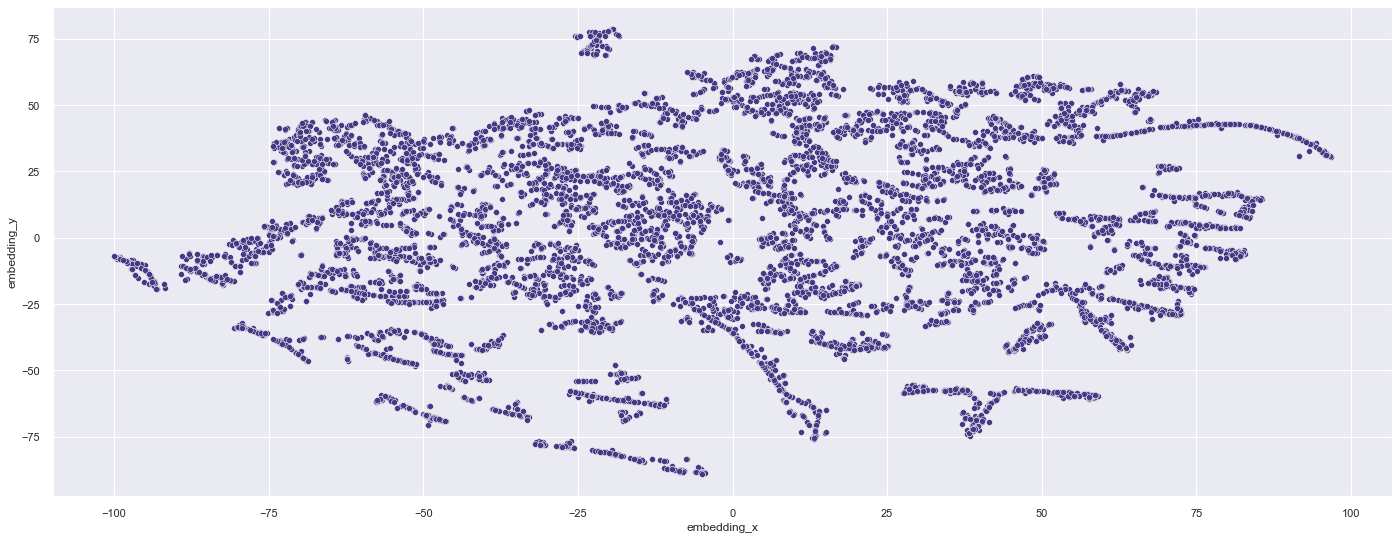

In [109]:
reducer = TSNE(n_components=2,
               n_jobs=-1,
               random_state=101)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame(embedding[:,0]).rename(columns={0:'embedding_x'})
df_tsne['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x',
                y = 'embedding_y',
                data = df_tsne)

### 4.3.4. Tree-Based Embedding

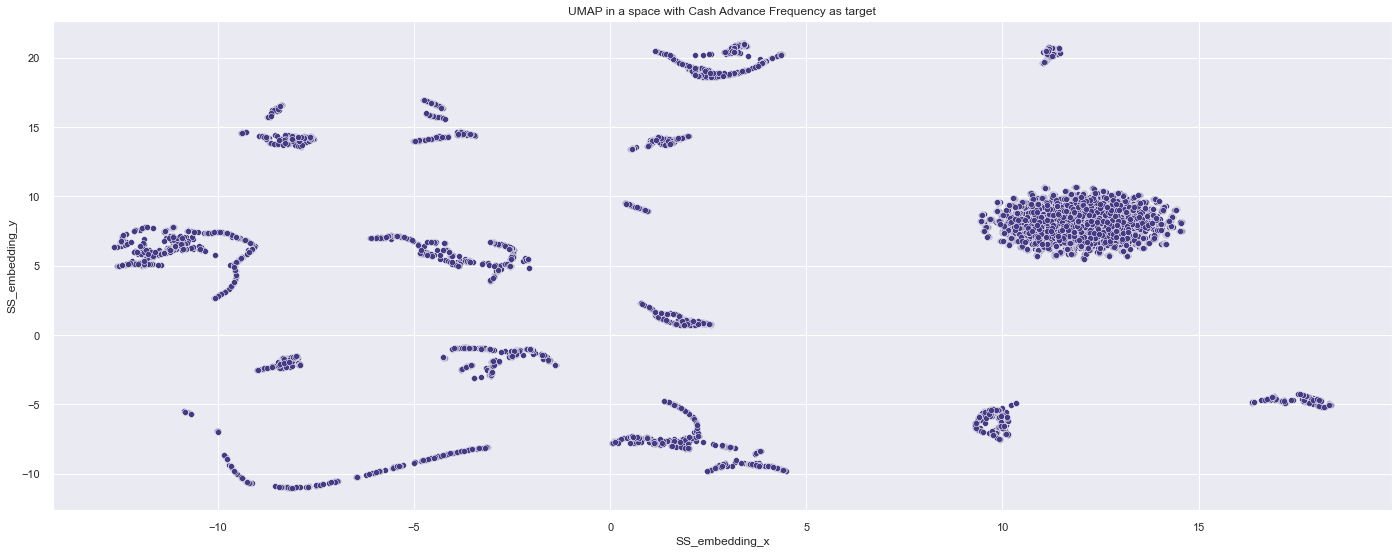

In [110]:
# training dataset
X = df_ref.drop(['cust_id','cash_advance_frequency'],axis=1)
y= df_ref['cash_advance_frequency']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap = pd.DataFrame(embedding[:,0]).rename(columns={0:'SS_embedding_x'})       
df_umap['SS_embedding_y'] = embedding[:,1]

# plotting
sns.scatterplot(x = 'SS_embedding_x',
                y = 'SS_embedding_y',
                data = df_umap);
plt.title('UMAP in a space with Cash Advance Frequency as target');

# 5. Data Preparation

In [94]:
df5 = df_ref.copy()

In [95]:
## Standard Scaler
ss = pp.StandardScaler()
mm = pp.MinMaxScaler()
rs = pp.RobustScaler()

df5['oneoff_purchases'] = mm.fit_transform(df5[['oneoff_purchases']])

df5['installments_purchases'] = mm.fit_transform(df5[['installments_purchases']])

df5['cash_advance'] = mm.fit_transform(df5[['cash_advance']])

# Frequency is already between 0 and 1
#df5['oneoff_purchases_frequency'] = mm.fit_transform(df5[['oneoff_purchases_frequency']])
#df5['purchases_installments_frequency'] = mm.fit_transform(df5[['purchases_installments_frequency']])
#df5['cash_advance_frequency'] = mm.fit_transform(df5[['cash_advance_frequency']])

df5['purchases_trx'] = mm.fit_transform(df5[['purchases_trx']])

df5['cash_advance_trx'] = mm.fit_transform(df5[['cash_advance_trx']])

df5['purchases_avg'] = mm.fit_transform(df5[['purchases_avg']])

df5['cash_advance_avg'] = mm.fit_transform(df5[['cash_advance_avg']])

In [96]:
df5.describe().T

,count,mean,std,min,25%,50%,75%,max
cust_id,8918.0,14599.079278,2651.552932,10001.0,12306.250000,14595.500000,16899.500000,19190.0
oneoff_purchases,8918.0,0.014570,0.040781,0.0,0.000000,0.000957,0.014282,1.0
installments_purchases,8918.0,0.018269,0.040161,0.0,0.000000,0.003972,0.020772,1.0
cash_advance,8918.0,0.020751,0.044503,0.0,0.000000,0.000000,0.023621,1.0
oneoff_purchases_frequency,8918.0,0.202913,0.298672,0.0,0.000000,0.083333,0.300000,1.0
purchases_installments_frequency,8918.0,0.364578,0.397465,0.0,0.000000,0.166667,0.750000,1.0
cash_advance_frequency,8918.0,0.134371,0.197766,0.0,0.000000,0.000000,0.222222,1.0
purchases_trx,8918.0,0.041139,0.069498,0.0,0.002793,0.019553,0.047486,1.0
cash_advance_trx,8918.0,0.026333,0.055409,0.0,0.000000,0.000000,0.032520,1.0
purchases_avg,8918.0,0.012361,0.026857,0.0,0.002007,0.006934,0.013176,1.0


# 6. Feature Selection

In [98]:
cols_selected = ['cust_id',
                 'oneoff_purchases',
                 'installments_purchases',
                 'cash_advance',
                 'oneoff_purchases_frequency',
                 'purchases_installments_frequency',
                 'cash_advance_frequency',
                 'purchases_trx',
                 'cash_advance_trx']

In [101]:
#df6 = df5[cols_selected].copy()
df6 = df_tree.copy()

# 7. Hyperparameter Fine-Tunning

In [102]:
#X = df6.drop('cust_id',axis=1)
X = df6

In [166]:
clusters = [2,3,4,5,6,7,8,9,10,11]

## 7.1. K-Means

For n_clusters=2 the average silhouette_score is:0.5579598546028137
For n_clusters=3 the average silhouette_score is:0.6543408036231995
For n_clusters=4 the average silhouette_score is:0.6549492478370667
For n_clusters=5 the average silhouette_score is:0.6559262871742249
For n_clusters=6 the average silhouette_score is:0.6691648960113525
For n_clusters=7 the average silhouette_score is:0.6903918981552124
For n_clusters=8 the average silhouette_score is:0.6840500831604004
For n_clusters=9 the average silhouette_score is:0.703000545501709
For n_clusters=10 the average silhouette_score is:0.7176140546798706
For n_clusters=11 the average silhouette_score is:0.46504008769989014


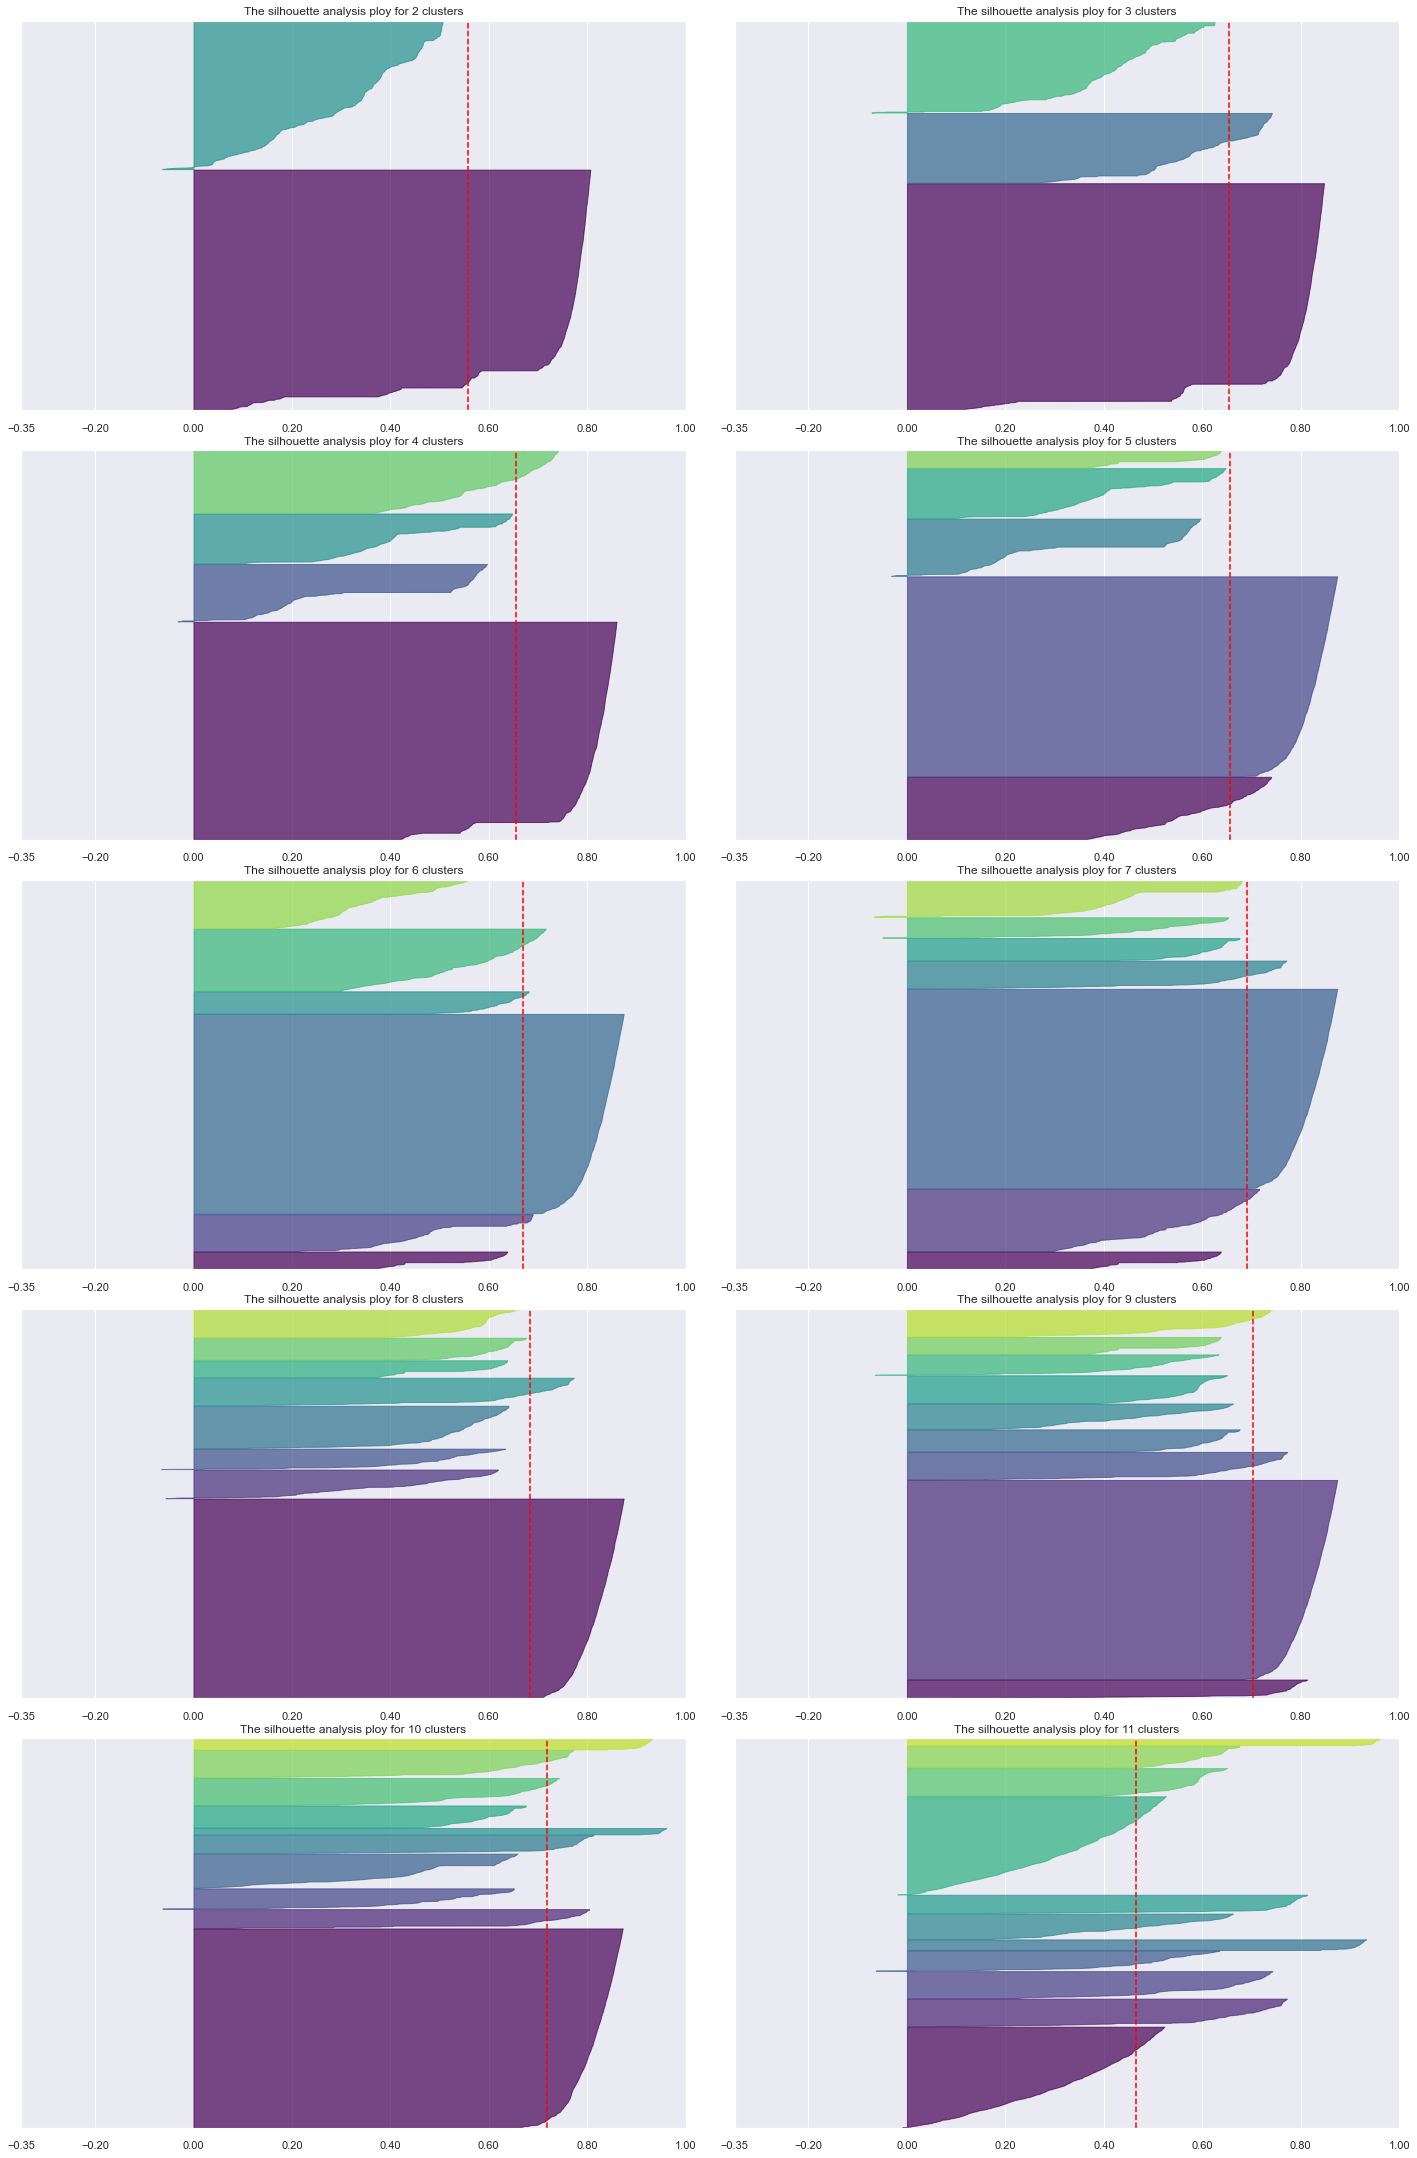

In [389]:
fig, ax = plt.subplots(5,2,figsize=(20,30))
fig.tight_layout()

kmeans_list = []

for k in clusters:    
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.35,1])
    ax[q-1,mod].set_ylim([-0.35,len(X)+(k+1)*10])
    
    # model definition, traning and predict
    km_model = c.KMeans(n_clusters=k,random_state=101)
    labels = km_model.fit_predict(X)

    # model performance
    silhouette_avg = m.silhouette_score(X, labels,metric='euclidean')
    kmeans_list.append(silhouette_avg)
    print(f'For n_clusters={k} the average silhouette_score is:{silhouette_avg}')
    samples_silhouette_values = m.silhouette_samples(X,labels)

    y_lower = 10
    for i in range(k):
        # select and order clusters samples
        ith_cluster_silhouette_values = samples_silhouette_values[labels==i]
        ith_cluster_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('viridis')
        color = cmap(i/k)
        
        ax[q-1,mod].fill_betweenx(
            np.arange(y_lower,y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)
        
        #ax[q-1,mod].text(-0.05,y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax[q-1,mod].set_title(f'The silhouette analysis ploy for {k} clusters')
    ax[q-1,mod].set_yticks([])
    ax[q-1,mod].set_xticks([-0.35,-.2,0,.2,.4,.6,.8,1])
    ax[q-1,mod].axvline(x=silhouette_avg,color='red',linestyle='--')
    
fig.set_size_inches=(20,40)

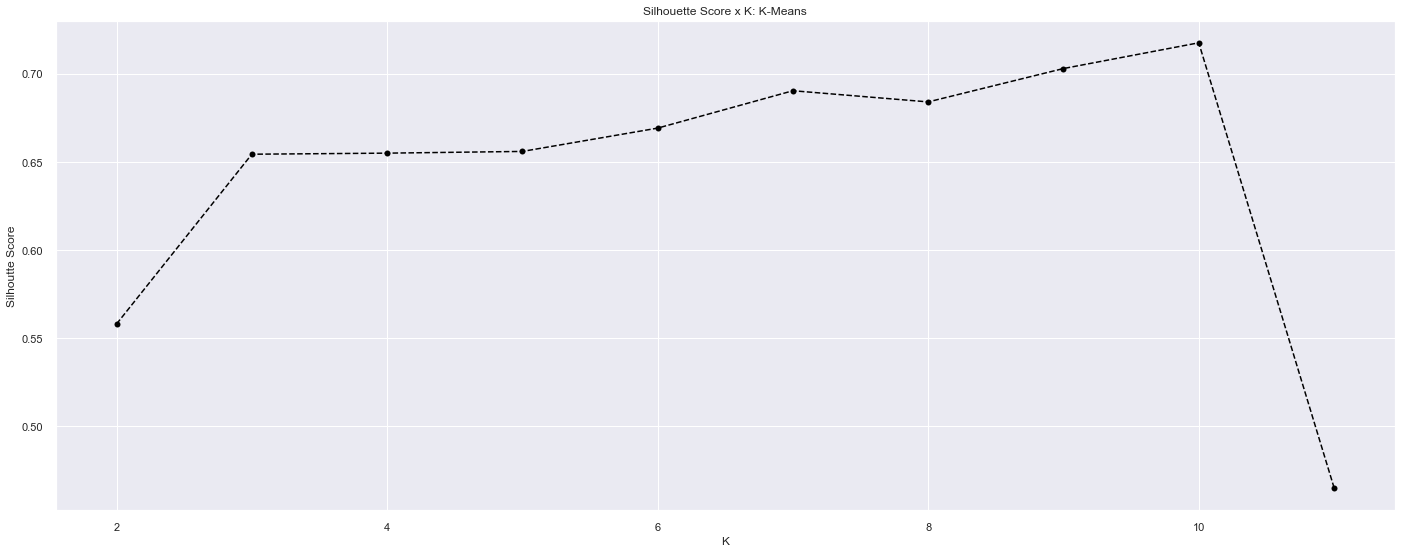

In [390]:
plt.plot(clusters,kmeans_list,linestyle='--',marker='o',color='black');
plt.xlabel('K');
plt.ylabel('Silhoutte Score');
plt.title('Silhouette Score x K: K-Means');

## 7.2. Gaussian Mixture Model (GMM)

For n_clusters=2 the average silhouette_score is:0.4797182083129883
For n_clusters=3 the average silhouette_score is:0.6298316717147827
For n_clusters=4 the average silhouette_score is:0.6351603865623474
For n_clusters=5 the average silhouette_score is:0.5805214047431946
For n_clusters=6 the average silhouette_score is:0.609324038028717
For n_clusters=7 the average silhouette_score is:0.6152245998382568
For n_clusters=8 the average silhouette_score is:0.6569209098815918
For n_clusters=9 the average silhouette_score is:0.6901734471321106
For n_clusters=10 the average silhouette_score is:0.683789074420929
For n_clusters=11 the average silhouette_score is:0.432119756937027


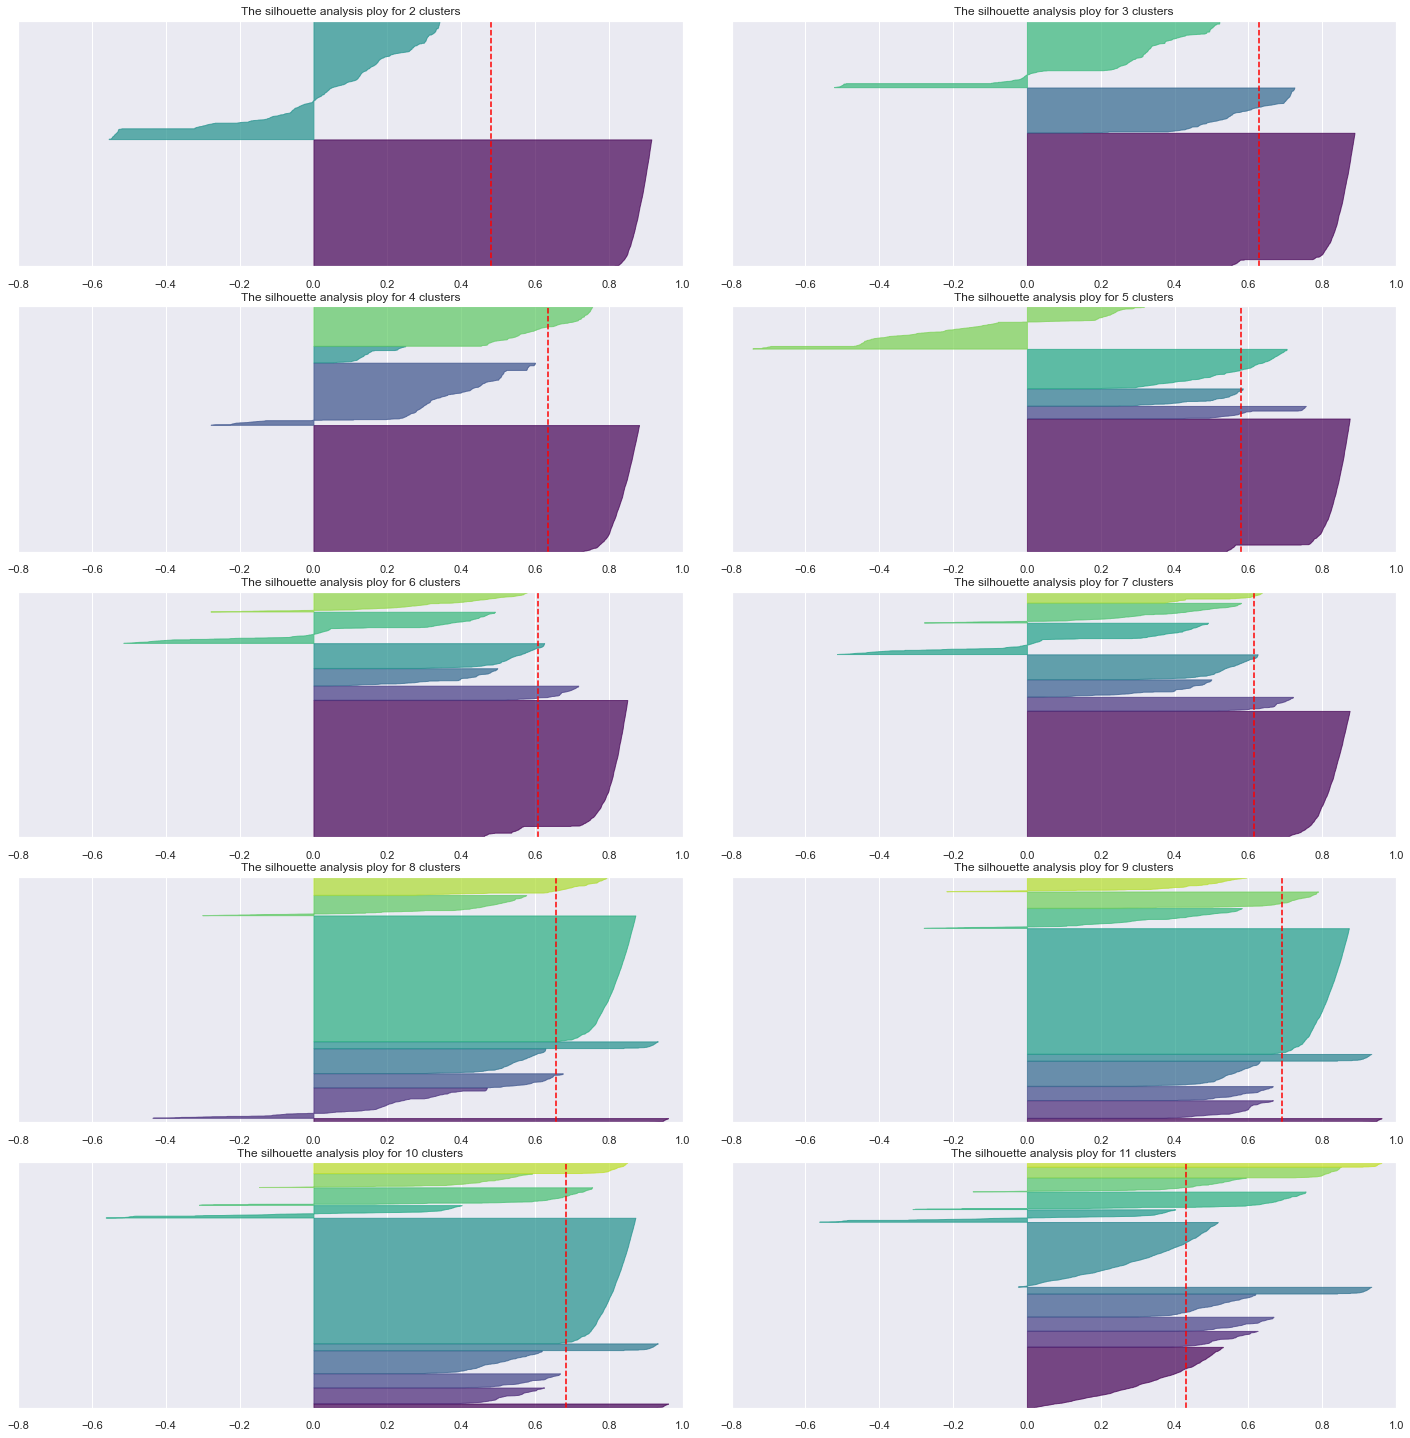

In [391]:
fig, ax = plt.subplots(5,2,figsize=(20,20))
fig.tight_layout()

gmm_list = []

for k in clusters:    
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-.8,1])
    ax[q-1,mod].set_ylim([-.8,len(X)+(k+1)*10])
    
    # model definition, traning and predict
    gm_model = mx.GaussianMixture(n_components = k,random_state=101)
    labels = gm_model.fit_predict(X)

    # model performance
    silhouette_avg = m.silhouette_score(X, labels,metric='euclidean')
    gmm_list.append(silhouette_avg)
    print(f'For n_clusters={k} the average silhouette_score is:{silhouette_avg}')
    samples_silhouette_values = m.silhouette_samples(X,labels)

    y_lower = 10
    for i in range(k):
        # select and order clusters samples
        ith_cluster_silhouette_values = samples_silhouette_values[labels==i]
        ith_cluster_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('viridis')
        color = cmap(i/k)
        
        ax[q-1,mod].fill_betweenx(
            np.arange(y_lower,y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)
        
        #ax[q-1,mod].text(-0.05,y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax[q-1,mod].set_title(f'The silhouette analysis ploy for {k} clusters')
    ax[q-1,mod].set_yticks([])
    ax[q-1,mod].set_xticks([-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1])
    ax[q-1,mod].axvline(x=silhouette_avg,color='red',linestyle='--')
    
fig.set_size_inches=(20,40)

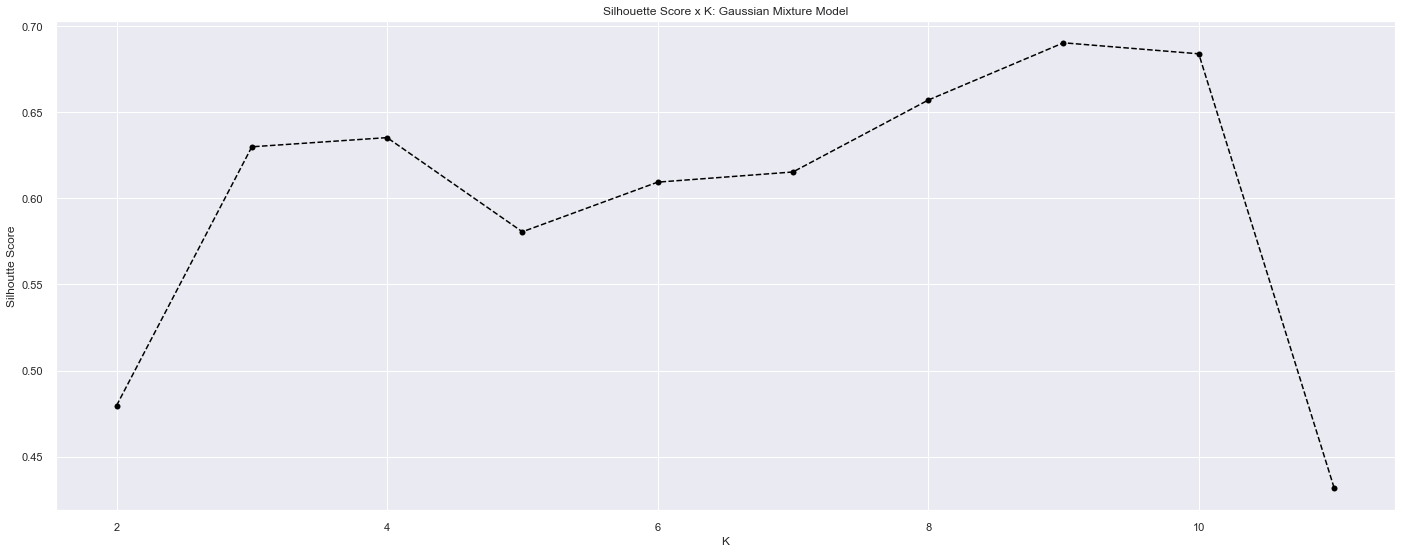

In [392]:
plt.plot(clusters,gmm_list,linestyle='--',marker='o',color='black');
plt.xlabel('K');
plt.ylabel('Silhoutte Score');
plt.title('Silhouette Score x K: Gaussian Mixture Model');

## 7.3. Hierarchical Clustering

### 7.3.1. Silhouette Score Analysis

For n_clusters=2 the average silhouette_score is:0.5512812733650208
For n_clusters=3 the average silhouette_score is:0.6539523601531982
For n_clusters=4 the average silhouette_score is:0.660223662853241
For n_clusters=5 the average silhouette_score is:0.6552973985671997
For n_clusters=6 the average silhouette_score is:0.6610618829727173
For n_clusters=7 the average silhouette_score is:0.6555848717689514
For n_clusters=8 the average silhouette_score is:0.6691778898239136
For n_clusters=9 the average silhouette_score is:0.68414705991745
For n_clusters=10 the average silhouette_score is:0.7036828398704529
For n_clusters=11 the average silhouette_score is:0.7173221707344055


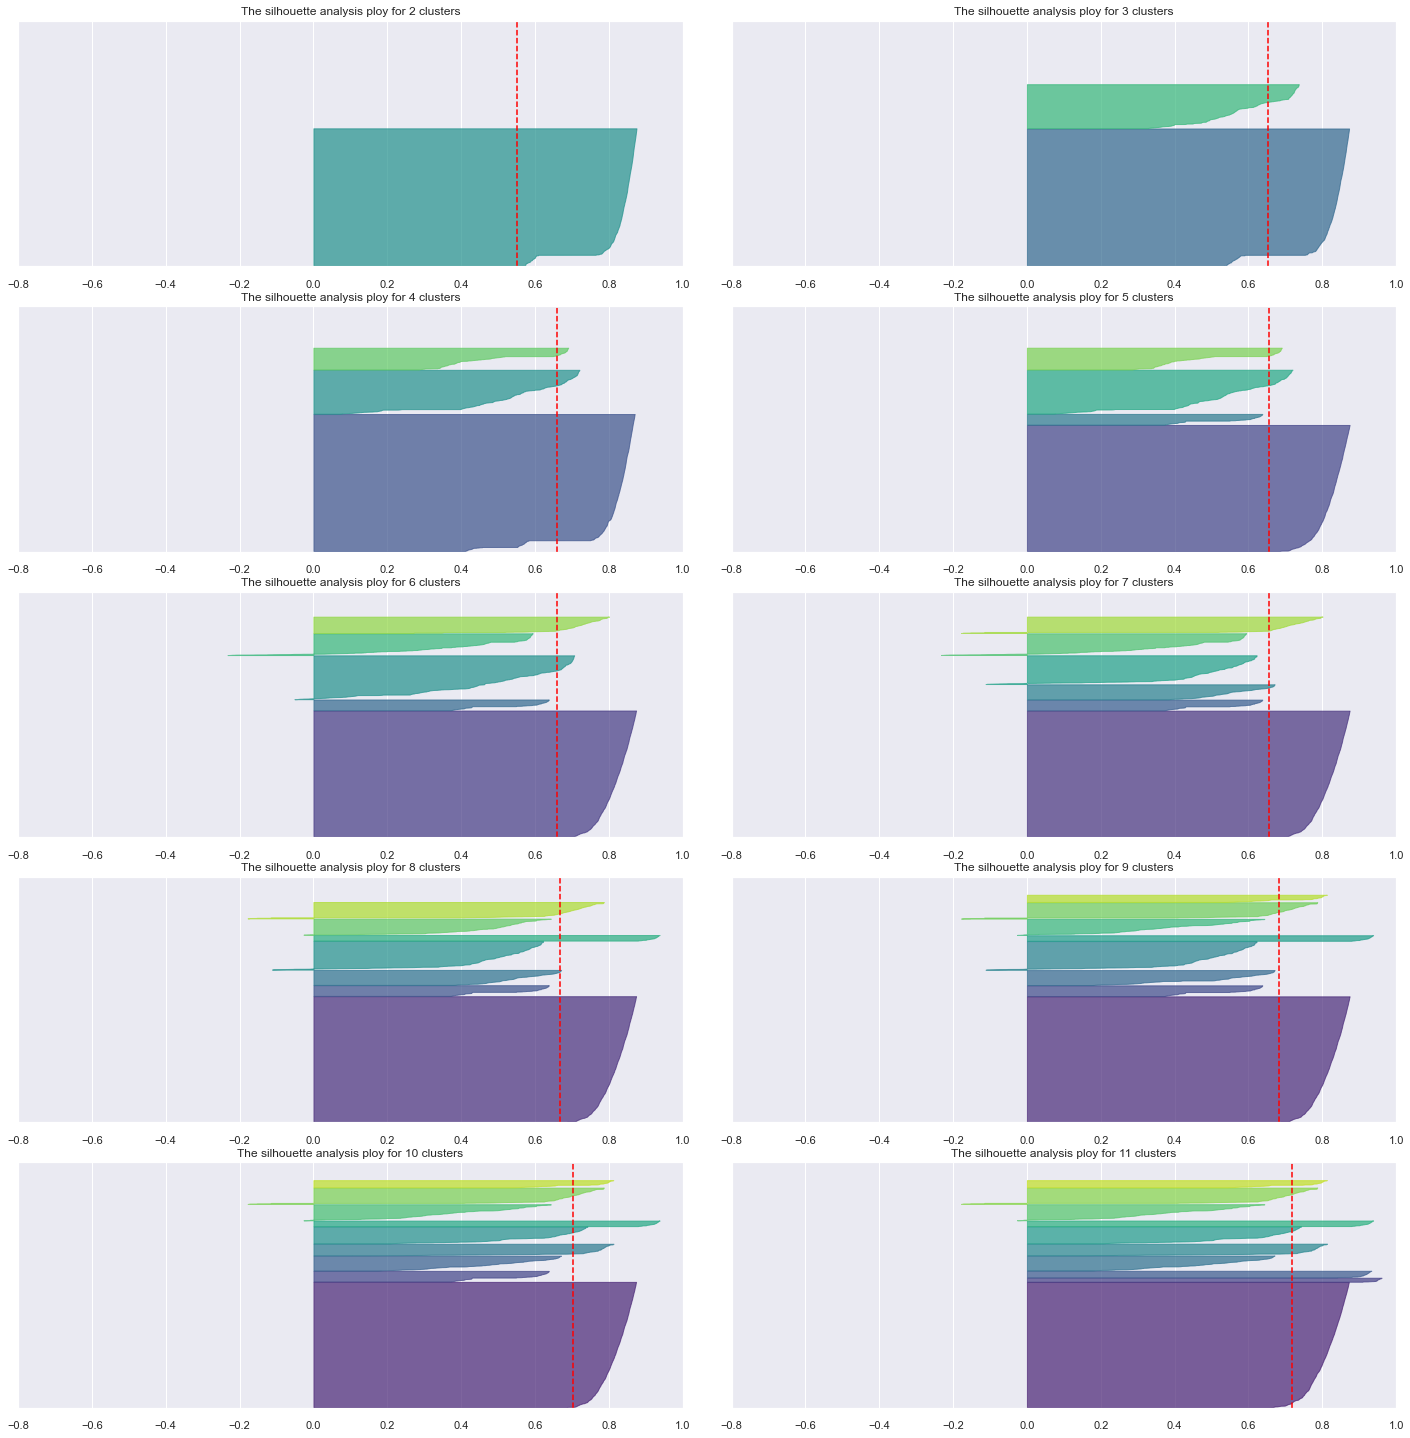

In [393]:
fig, ax = plt.subplots(5,2,figsize=(20,20))
fig.tight_layout()

hc_list = []
hc_model = h.linkage(X,'ward')

for k in clusters:    
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-.8,1])
    ax[q-1,mod].set_ylim([-.8,len(X)+(k+1)*10])
    
    # model definition, traning and predict
    labels = h.fcluster(hc_model,k,criterion='maxclust')
                         
    # model performance
    silhouette_avg = m.silhouette_score(X, labels,metric='euclidean')
    hc_list.append(silhouette_avg)
    print(f'For n_clusters={k} the average silhouette_score is:{silhouette_avg}')
    samples_silhouette_values = m.silhouette_samples(X,labels)

    y_lower = 10
    for i in range(k):
        # select and order clusters samples
        ith_cluster_silhouette_values = samples_silhouette_values[labels==i]
        ith_cluster_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('viridis')
        color = cmap(i/k)
        
        ax[q-1,mod].fill_betweenx(
            np.arange(y_lower,y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)
        
        #ax[q-1,mod].text(-0.05,y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax[q-1,mod].set_title(f'The silhouette analysis ploy for {k} clusters')
    ax[q-1,mod].set_yticks([])
    ax[q-1,mod].set_xticks([-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1])
    ax[q-1,mod].axvline(x=silhouette_avg,color='red',linestyle='--')
    
fig.set_size_inches=(20,40)

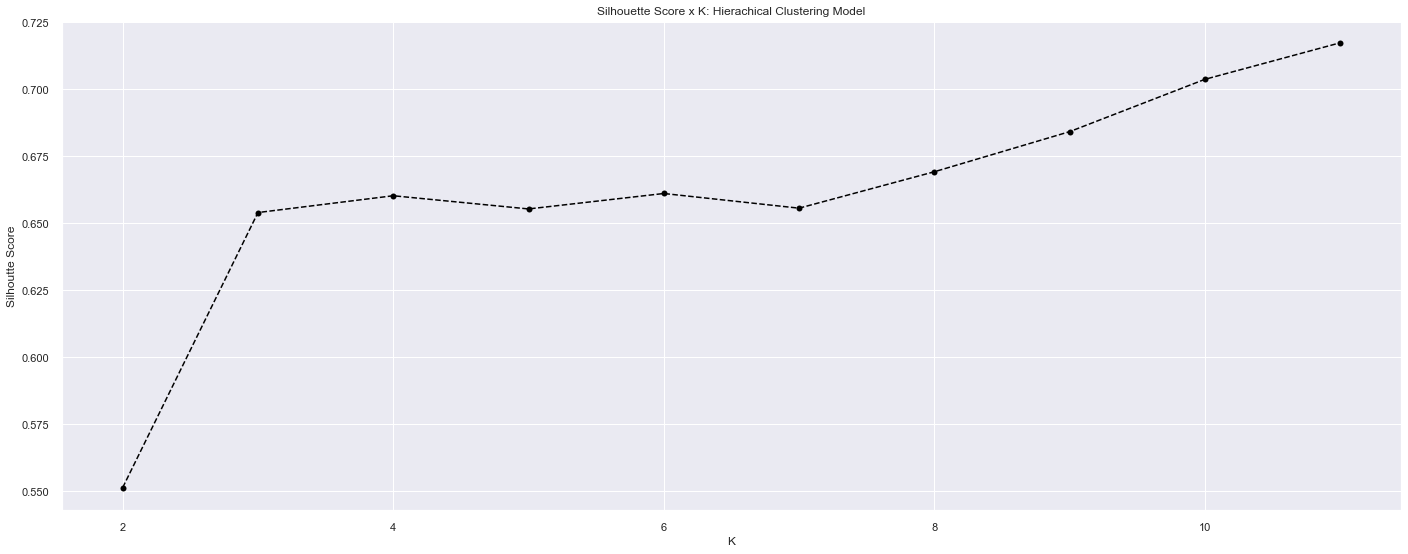

In [394]:
plt.plot(clusters,hc_list,linestyle='--',marker='o',color='black');
plt.xlabel('K');
plt.ylabel('Silhoutte Score');
plt.title('Silhouette Score x K: Hierachical Clustering Model');

### 7.3.2. HClustering Dendrogram

In [174]:
hex_colors = list(map(mpl.colors.rgb2hex, sns.color_palette('viridis', 5)))

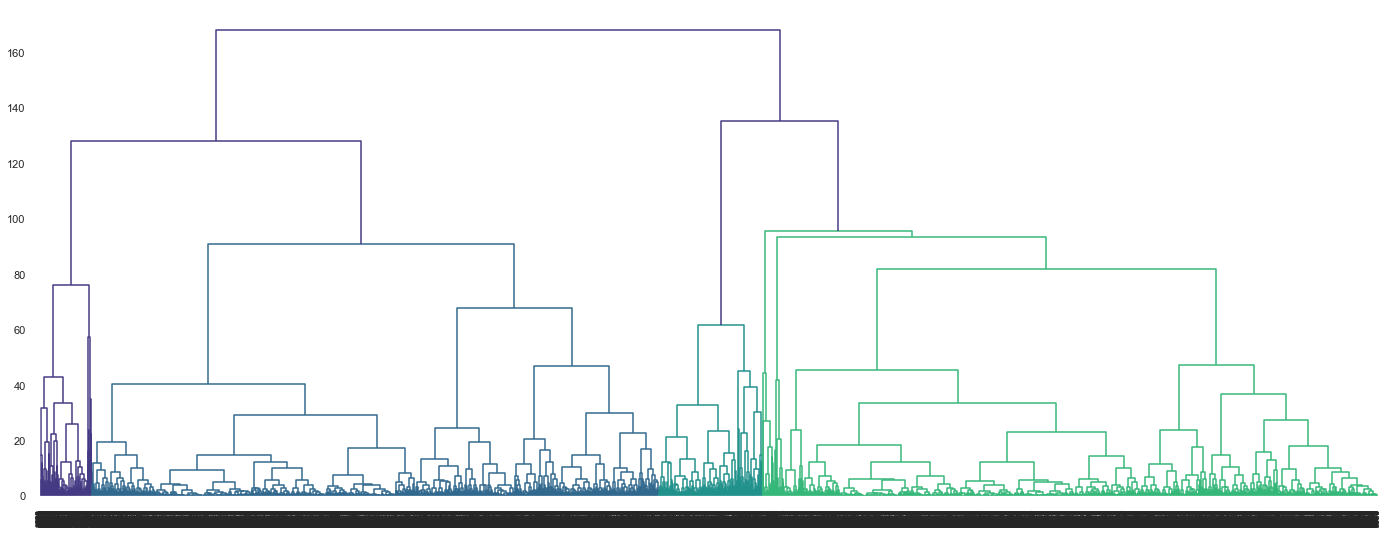

In [143]:
h.set_link_color_palette(hex_colors)
h.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.show()

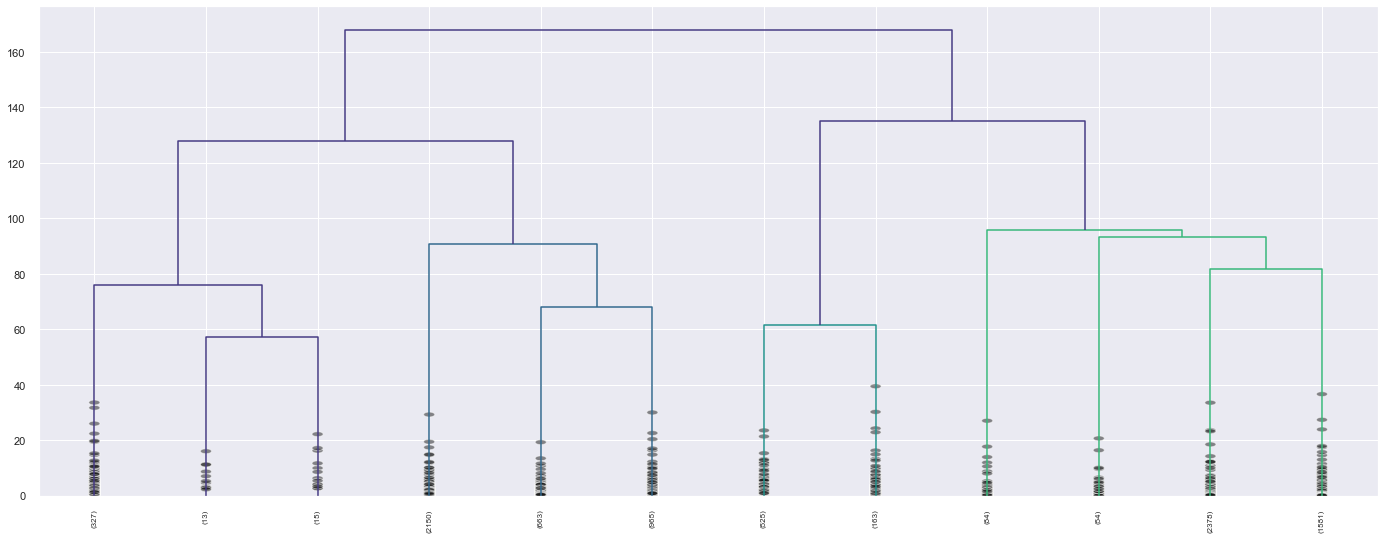

In [144]:
h.set_link_color_palette(hex_colors)
h.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

## 7.4. DBSCAN

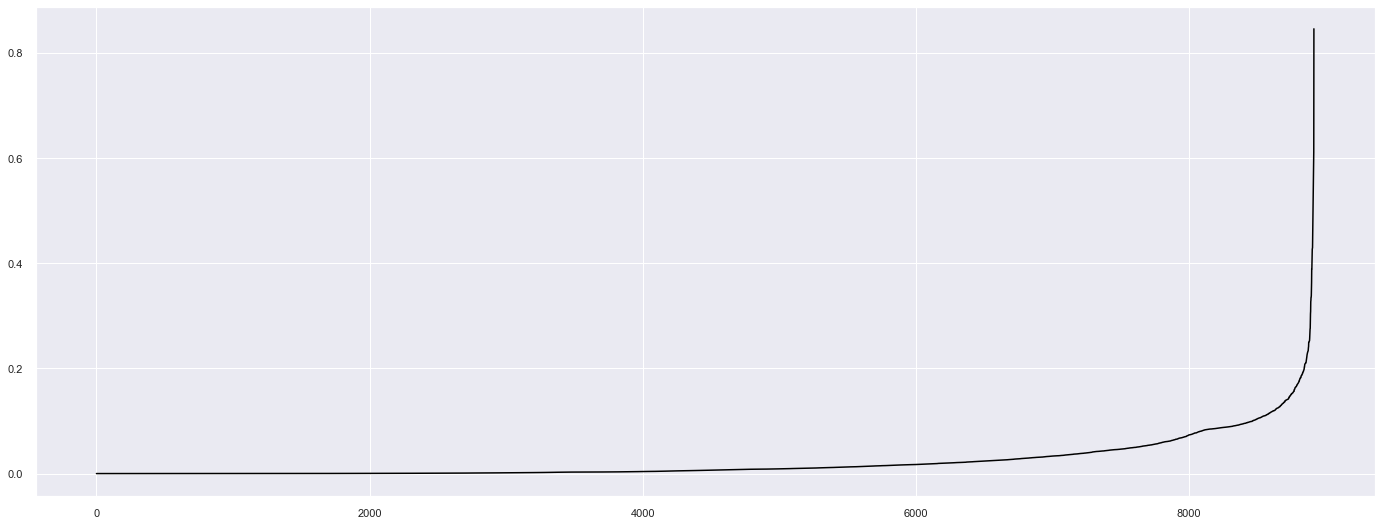

In [175]:
min_samples = 20
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances,indices = neighbors.kneighbors(X)
distances = np.sort(distances,axis=0)
distances = distances[:,1]
plt.plot(distances,color='black');

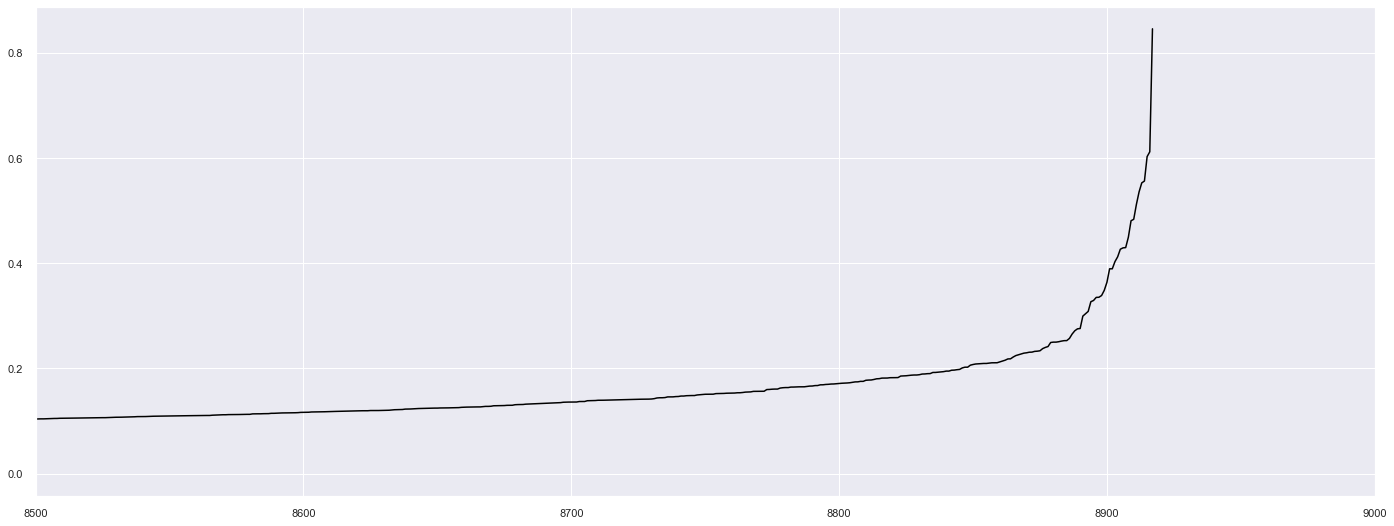

In [177]:
plt.plot(distances,color='black');
plt.xlim(left=8500,right=9000);

In [303]:
num_clusters = []
ss_list = []
eps_list = []
min_list = []
for eps in np.linspace(.2,.45,30):
    print(f'eps = {eps}')
    for min_samples in np.linspace(1.01,3,30):
        dbscan_model = c.DBSCAN(eps=eps,min_samples=min_samples)
        labels = dbscan_model.fit_predict(X)
        num_clusters.append(np.unique(len(np.unique(labels))-1))
        ss_list.append(m.silhouette_score(X, labels))
        eps_list.append(eps)
        min_list.append(min_samples)

eps = 0.2
eps = 0.20862068965517241
eps = 0.21724137931034485
eps = 0.22586206896551725
eps = 0.23448275862068968
eps = 0.24310344827586208
eps = 0.2517241379310345
eps = 0.2603448275862069
eps = 0.2689655172413793
eps = 0.2775862068965517
eps = 0.28620689655172415
eps = 0.29482758620689653
eps = 0.30344827586206896
eps = 0.3120689655172414
eps = 0.32068965517241377
eps = 0.32931034482758625
eps = 0.33793103448275863
eps = 0.346551724137931
eps = 0.3551724137931035
eps = 0.36379310344827587
eps = 0.3724137931034483
eps = 0.38103448275862073
eps = 0.3896551724137931
eps = 0.39827586206896554
eps = 0.40689655172413797
eps = 0.41551724137931034
eps = 0.4241379310344828
eps = 0.4327586206896552
eps = 0.4413793103448276
eps = 0.45


In [304]:
aux1 = pd.DataFrame({'score':ss_list,
                     'n_clusters':num_clusters,
                     'epsilon':eps_list,
                     'min_samples':min_list
                    })
aux1['n_clusters'] = aux1['n_clusters'].apply(lambda x: x[0])
aux1.groupby('n_clusters')['score'].max()

n_clusters
1    0.519192
2    0.408655
3    0.377340
4    0.317837
5    0.181156
6    0.161031
7    0.058309
8    0.056807
Name: score, dtype: float64

In [325]:
aux1.iloc[[720,135,180,150,120,30,60]]

,score,n_clusters,epsilon,min_samples
720,0.408655,2,0.406897,1.01000
135,0.377340,3,0.234483,2.03931
180,0.317837,4,0.251724,1.01000
150,0.181156,5,0.243103,1.01000
120,0.161031,6,0.234483,1.01000
30,0.058309,7,0.208621,1.01000
60,0.056807,8,0.217241,1.01000


In [ ]:
dbscan_list = aux1.groupby('n_clusters')['score'].max().to_list()[1:]

for i in range(3):
    dbscan_list.append(0)

## 7.5. Results

In [395]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'Hierarchical': hc_list,
    # 'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [396]:
df_results.style.highlight_max(color='lightgreen',axis=1)

,2,3,4,5,6,7,8,9,10,11
KMeans,0.557960,0.654341,0.654949,0.655926,0.669165,0.690392,0.684050,0.703001,0.717614,0.465040
GMM,0.479718,0.629832,0.635160,0.580521,0.609324,0.615225,0.656921,0.690173,0.683789,0.432120
Hierarchical,0.551281,0.653952,0.660224,0.655297,0.661062,0.655585,0.669178,0.684147,0.703683,0.717322


# 8. Model Training

## 8.1. K-Means

In [106]:
# Model Definition
k = 13
#kmeans = c.KMeans(init='random',n_clusters=k,random_state=101)
hc_model = h.linkage(X,'ward')

# Model Training
#kmeans.fit(X)
labels = h.fcluster(hc_model,k,criterion='maxclust')

# Clustering
#labels = kmeans.labels_

## 8.2. Cluster Validation

In [108]:
# WWS (Within-Cluster Sum of Square)
print('WWS value: {:.2f}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {:.2f}'.format(m.silhouette_score(X,labels)))

SS value: 0.75


# 9. Cluster Analysis

In [109]:
df9 = df3[['cust_id',
           'oneoff_purchases',
           'installments_purchases',
           'cash_advance',
           'oneoff_purchases_frequency',
           'purchases_installments_frequency',
           'cash_advance_frequency',
           'purchases_trx',
           'cash_advance_trx']].copy()
df9['cluster'] = labels
df9.head()

,cust_id,oneoff_purchases,installments_purchases,cash_advance,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,purchases_trx,cash_advance_trx,cluster
0,10001,0.00,95.4,0.000000,0.000000,0.083333,0.000000,2,0,1
1,10002,0.00,0.0,6442.945483,0.000000,0.000000,0.250000,0,4,8
2,10003,773.17,0.0,0.000000,1.000000,0.000000,0.000000,12,0,1
3,10004,1499.00,0.0,205.788017,0.083333,0.000000,0.083333,1,1,3
4,10005,16.00,0.0,0.000000,0.083333,0.000000,0.000000,1,0,1


## 9.1. Two-Dimentions Plot

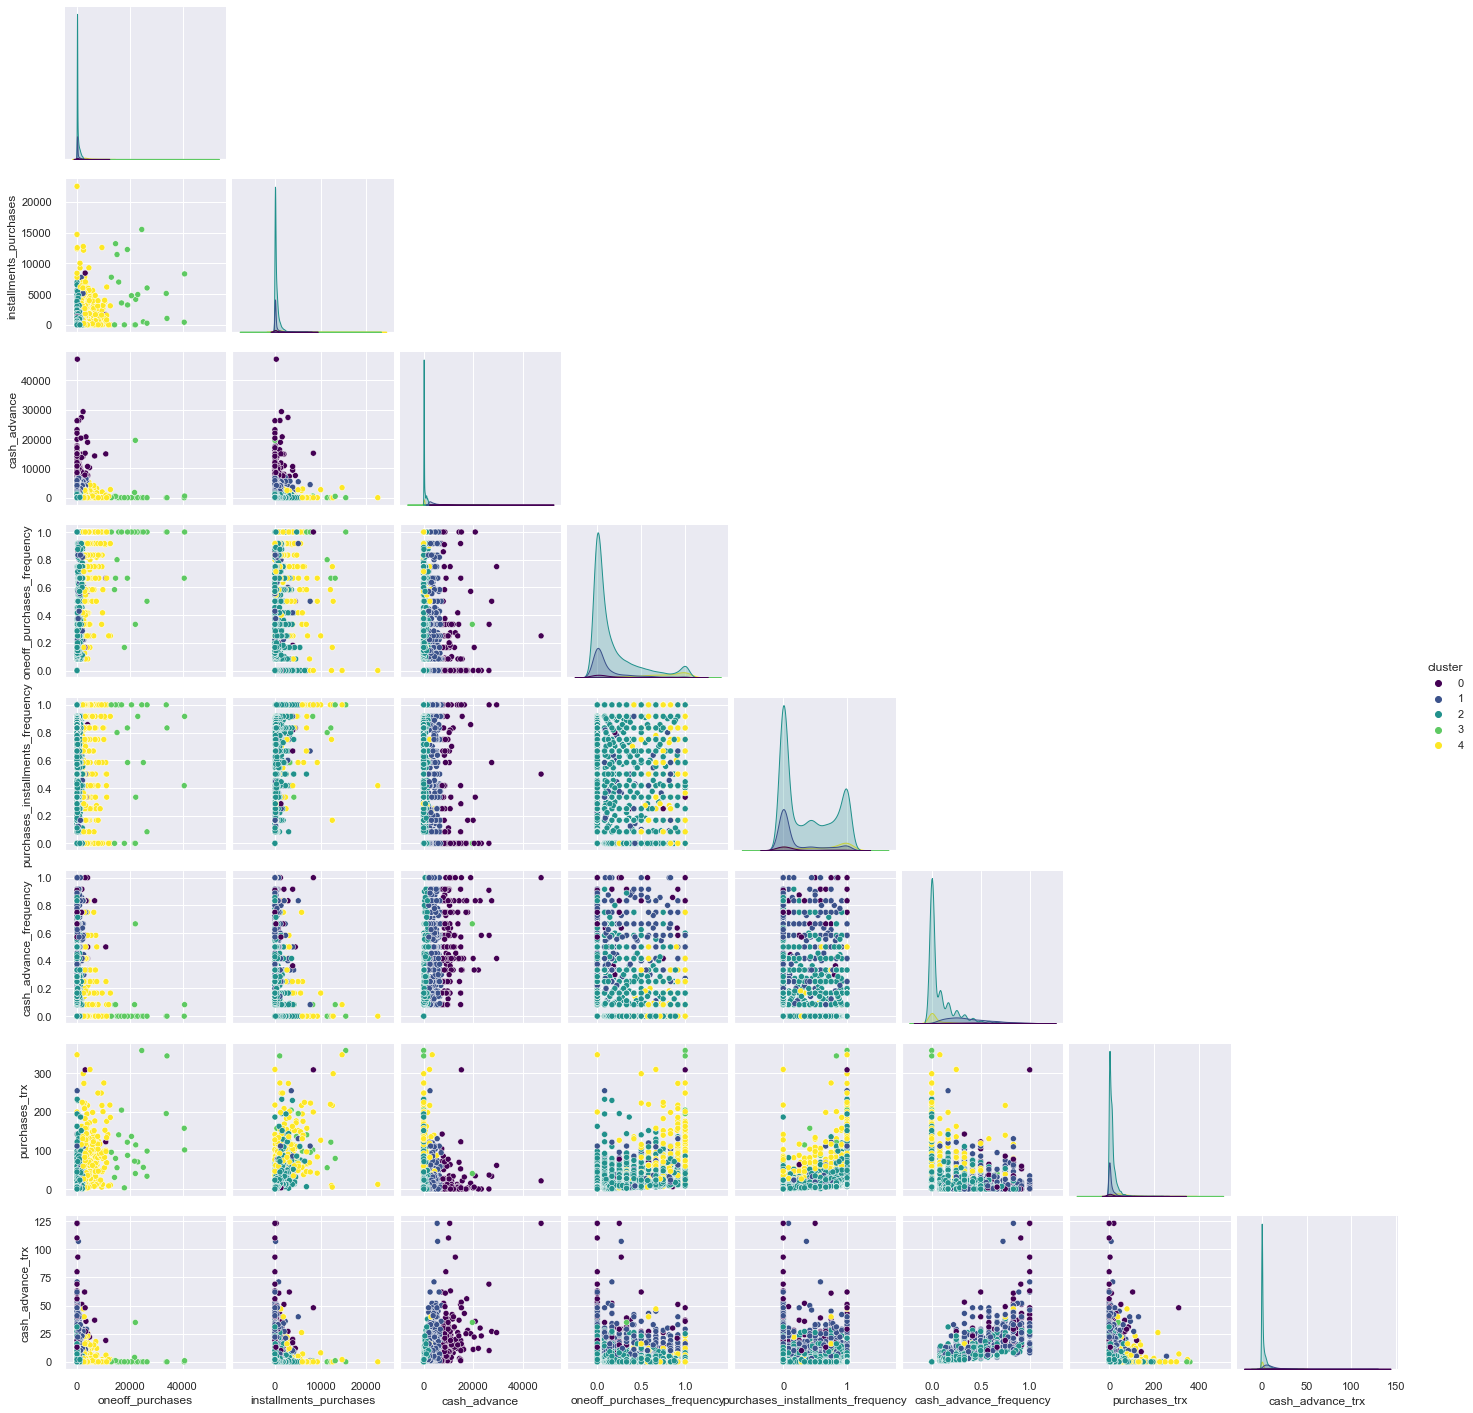

In [384]:
df_viz = df9.drop('cust_id',axis=1)
sns.pairplot(df_viz,hue='cluster',palette='viridis',corner=True);

## 9.2. UMAP

In [422]:
df9=X.copy()
df9['cluster'] = labels

In [423]:
df9.head()

,MM_embedding_x,MM_embedding_y,cluster
0,12.438543,3.905333,1
1,1.051759,8.570407,5
2,15.299336,5.417115,1
3,3.968079,-3.030443,11
4,12.422149,3.906936,1


<AxesSubplot:xlabel='MM_embedding_x', ylabel='MM_embedding_y'>

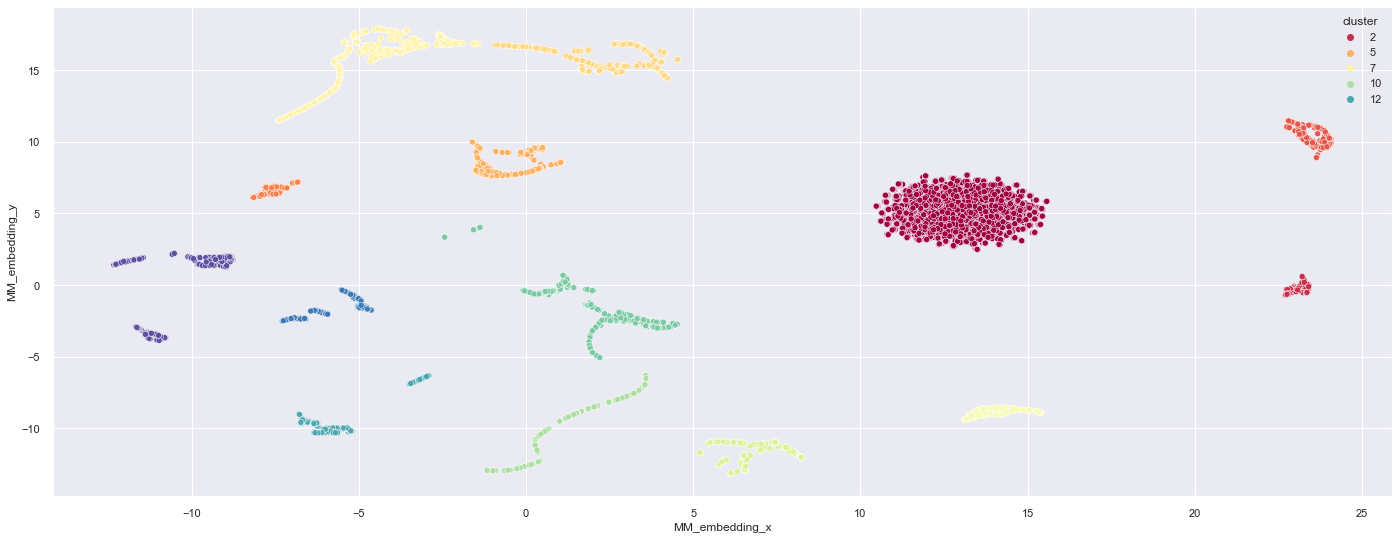

In [424]:
sns.scatterplot(x='MM_embedding_x',y='MM_embedding_y',hue='cluster',data=df9,palette='Spectral')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

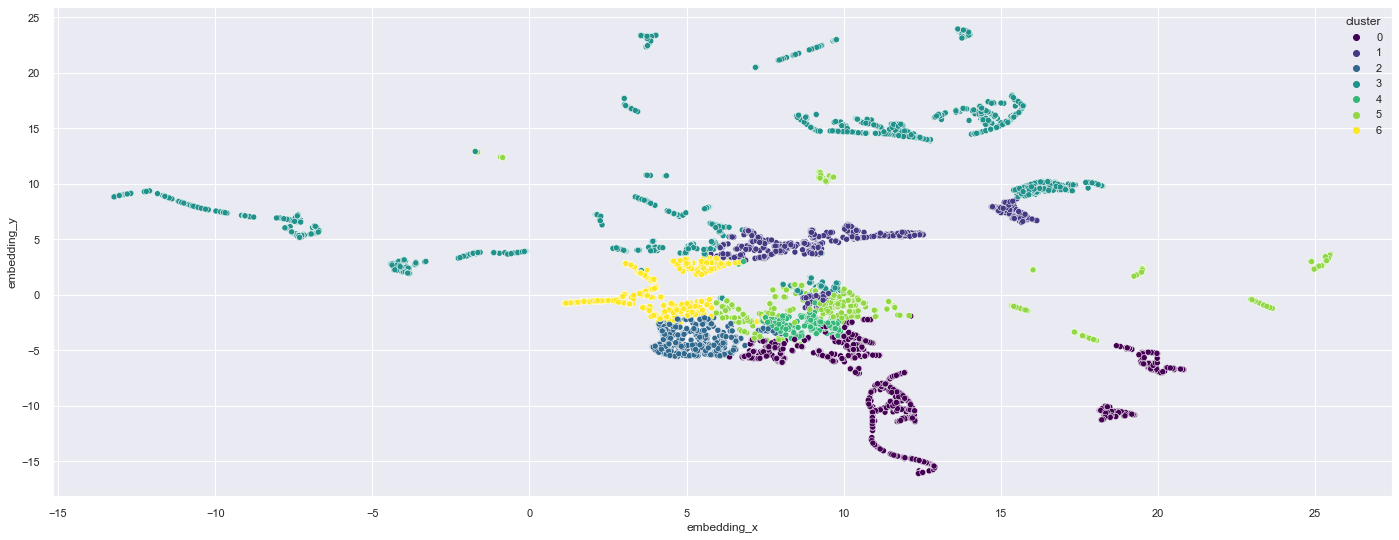

In [366]:
# Quciker from larger datasets but more difficult to visualize
# Change n_neighbors to see something similar to a local structure (\/) ou global structure (/\)
reducer = umap.UMAP(n_neighbors=25,random_state=101)
embedding = reducer.fit_transform(X)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',data=df_viz,hue='cluster',palette='viridis')

## 9.3. Cluster Profile

In [110]:
df9.columns.tolist()[1:-1]

['oneoff_purchases',
 'installments_purchases',
 'cash_advance',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'cash_advance_frequency',
 'purchases_trx',
 'cash_advance_trx']

In [111]:
df_cluster = df9[['cust_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['cust_id']/df_cluster['cust_id'].sum()),2)

for feature in df9.columns.tolist()[0:-1]:
  df_aux = df9[[feature,'cluster']].groupby('cluster').mean().reset_index()
  df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

In [112]:
df_cluster

,cluster,cust_id_x,perc_customer,cust_id_y,oneoff_purchases,installments_purchases,cash_advance,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,purchases_trx,cash_advance_trx
0,1,4612,51.72,14671.352992,777.959764,571.791477,0.000000,0.257455,0.506441,0.000000,19.459020,0.000000
1,2,284,3.18,14631.887324,0.000000,0.190317,298.293846,0.000000,0.000587,0.089437,0.007042,1.000000
2,3,601,6.74,14249.467554,706.625940,389.230233,888.978523,0.215693,0.325179,0.089137,13.870216,1.000000
3,4,394,4.42,14625.446701,379.856853,231.316751,2518.550808,0.142764,0.218178,0.359662,9.776650,7.502538
4,5,266,2.98,14626.733083,414.870564,228.294737,3953.969062,0.155042,0.212219,0.547129,10.127820,15.996241
5,6,267,2.99,14462.179775,433.316105,192.398277,3568.792636,0.145042,0.199956,0.464020,9.662921,11.895131
6,7,374,4.19,14262.508021,498.715080,336.186337,5111.802925,0.181252,0.243972,0.602752,13.564171,24.601604
7,8,382,4.28,14583.096859,366.123115,249.080000,1481.687507,0.146575,0.233001,0.235986,9.821990,4.000000
8,9,171,1.92,14632.941520,280.545556,216.540351,2536.820218,0.129858,0.191035,0.357940,7.286550,8.000000
9,10,366,4.10,14440.726776,370.403033,204.990792,1465.532151,0.147128,0.226615,0.197562,9.032787,3.000000


###  <span style="color:red"> The resulting clusters become totally biased by the feature that was the target in the creation of the df_tree (cash_advance_frequency), and as there is a high correlation between it and the other features that deal with cash advance, the analysis of those that do not have correlation loses quality significantly. </span>

# 10. Deploy to Production